In [1]:
##Bibliotecas
from time import time
from os.path import exists, join
import pandas as pd
import numpy as np
from os import mkdir
from numpy import mean, std, sum, min, delete
from pandas import read_csv, concat
from scripts.utils import (load_data, save_fig, create_subreport, save_report,
                           filter_out_low_WAPS)
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, RandomizedSearchCV, cross_validate
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from scripts.models import (load_KNN, load_Random_Forest, load_SVM,
                           load_Decision_Tree, threshold_variance, pca)
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from pandas import DataFrame, concat
from scripts.errors import compute_errors
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import fetch_openml
from sklearn.feature_selection import SelectKBest, mutual_info_classif, mutual_info_regression
from scripts.errors import localizaion_error
from numpy import mean, std, sum, min, delete, sqrt, square
from sklearn.svm import SVR, SVC
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.multioutput import MultiOutputRegressor, MultiOutputClassifier
from scipy.stats import randint
from statistics import mean, stdev

## 1. Pré Processamento

Nessa etapa vamos verificar redundâncias, inconsistêcias, ruídos, incompletudes, além da caracterização estatística dos dados.

Primeiro vamos carregar os dados:

In [2]:
train_fname = "trainingData.csv"
val_fname = "validationData.csv"
N = 520
CATEGORICAL_COLUMNS = ['FLOOR', 'BUILDINGID'] # Classification Columns
QUANTITATIVE_COLUMNS = ['LONGITUDE', 'LATITUDE'] # Regression Columns

# drop_columns = ["SPACEID", "RELATIVEPOSITION", "USERID"]
drop_columns = ["RELATIVEPOSITION", "USERID"]

data = read_csv("data/" + train_fname)
data_val = read_csv("data/" + val_fname)

# Drop useless columns if there are any specified.
data.drop(columns=drop_columns, inplace=True)
data_val.drop(columns=drop_columns, inplace=True)

# Phone 17s data is clearly corrupted. 
data = data[data.PHONEID != 17] 
data_val = data_val[data_val.PHONEID != 17] 

# Split training data from labels
X = data.iloc[:, :N]
Y = data.iloc[:, N:]

# Split validation data from labels
X_teste = data_val.iloc[:, :N]
y_teste = data_val.iloc[:, N:]

### 1.1 Dimensionalidade e número de atributos por WAPs

Gráfico non-null sample

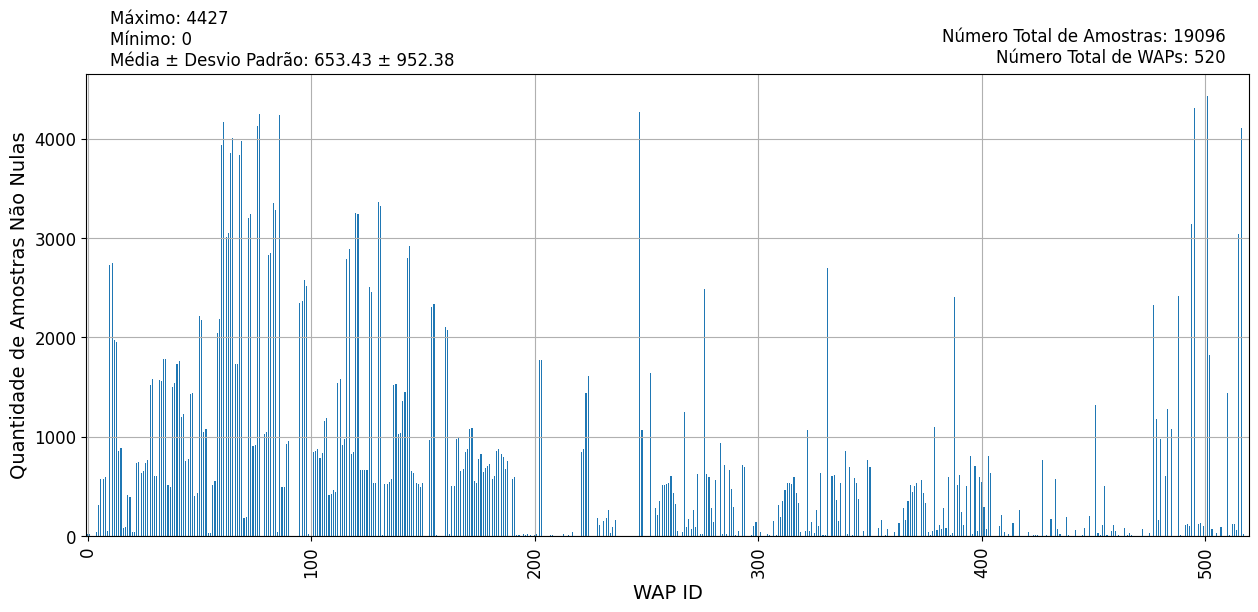

In [11]:
# Função para contar valores diferentes de 100
def contar_diferentes_de_100(coluna):
    return coluna[coluna != 100].count()

# Aplica a função a cada coluna WAP
contagem_waps = data.iloc[:, :520].apply(contar_diferentes_de_100)

plt.figure(figsize=(15, 6))
contagem_waps.plot(kind='bar')

# Ajuste o tamanho da fonte nos eixos
plt.xticks(range(0, len(contagem_waps), 100), range(0, len(contagem_waps), 100), fontsize=12)
plt.yticks(fontsize=12)

# Adiciona informações no canto superior esquerdo
maximo = contagem_waps.max()
minimo = contagem_waps.min()
media = contagem_waps.mean()
desvio_padrao = contagem_waps.std()
plt.text(0.02, 1.14, f'Máximo: {maximo}\nMínimo: {minimo}\nMédia ± Desvio Padrão: {media:.2f} ± {desvio_padrao:.2f}',
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left')

# Adiciona informações no canto superior direito
num_amostras = len(data)
num_waps = len(contagem_waps)
plt.text(0.98, 1.1, f'Número Total de Amostras: {num_amostras}\nNúmero Total de WAPs: {num_waps}',
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='right')         

# Ajuste o tamanho da fonte nos rótulos e na legenda
plt.xlabel('WAP ID', fontsize=14)
plt.ylabel('Quantidade de Amostras Não Nulas', fontsize=14)
plt.grid()

# Ajuste o tamanho da fonte do título
#plt.title('Quantidade de Amostras Não Nulas por WAP', fontsize=16)

plt.show()


Já para o conjunto de teste

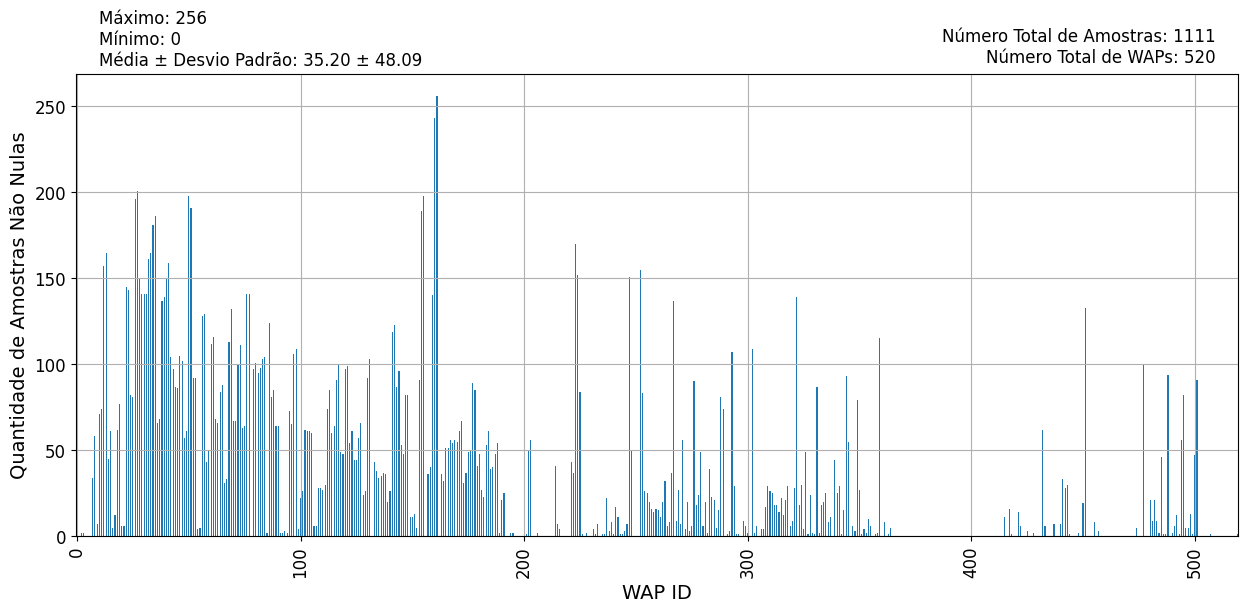

In [12]:
# Função para contar valores diferentes de 100
def contar_diferentes_de_100(coluna):
    return coluna[coluna != 100].count()

# Aplica a função a cada coluna WAP
contagem_waps = data_val.iloc[:, :520].apply(contar_diferentes_de_100)

plt.figure(figsize=(15, 6))
contagem_waps.plot(kind='bar')

# Ajuste o tamanho da fonte nos eixos
plt.xticks(range(0, len(contagem_waps), 100), range(0, len(contagem_waps), 100), fontsize=12)
plt.yticks(fontsize=12)

# Adiciona informações no canto superior esquerdo
maximo = contagem_waps.max()
minimo = contagem_waps.min()
media = contagem_waps.mean()
desvio_padrao = contagem_waps.std()
plt.text(0.02, 1.14, f'Máximo: {maximo}\nMínimo: {minimo}\nMédia ± Desvio Padrão: {media:.2f} ± {desvio_padrao:.2f}',
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left')

# Adiciona informações no canto superior direito
num_amostras = len(data_val)
num_waps = len(contagem_waps)
plt.text(0.98, 1.1, f'Número Total de Amostras: {num_amostras}\nNúmero Total de WAPs: {num_waps}',
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='right')         

# Ajuste o tamanho da fonte nos rótulos e na legenda
plt.xlabel('WAP ID', fontsize=14)
plt.ylabel('Quantidade de Amostras Não Nulas', fontsize=14)
plt.grid()

# Ajuste o tamanho da fonte do título
#plt.title('Quantidade de Amostras Não Nulas por WAP', fontsize=16)

plt.show()


### 1.2 Inconsistências, duplicidades, ruídos e balanceamento


building and floor counts

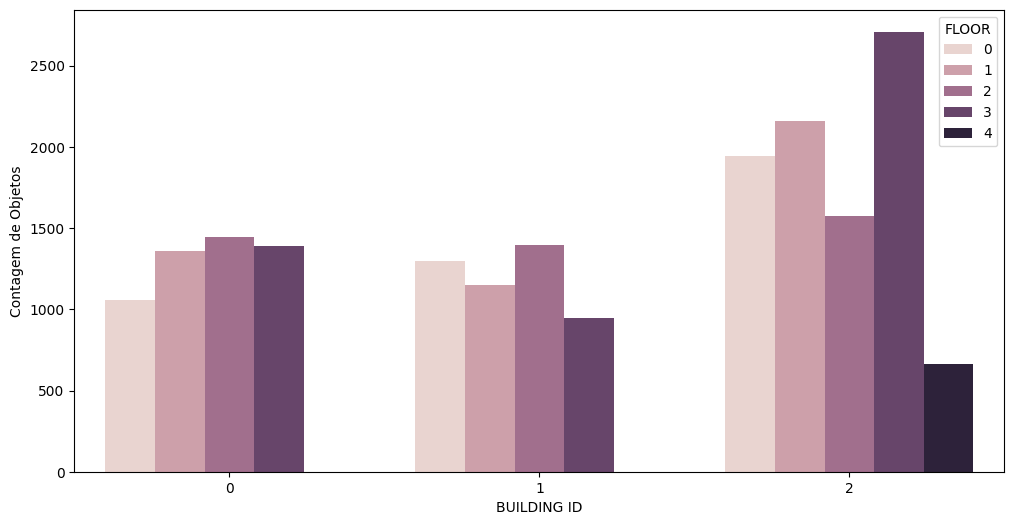

In [37]:
plt.figure(figsize=(12, 6))
sns.countplot(data=data, x='BUILDINGID', hue='FLOOR')
#plt.title('Contagem de Amostras por BUILDING ID e FLOOR')
plt.xlabel('BUILDING ID')
plt.ylabel('Contagem de Objetos')
plt.show()

Lat vs lon em comparação com o mapa

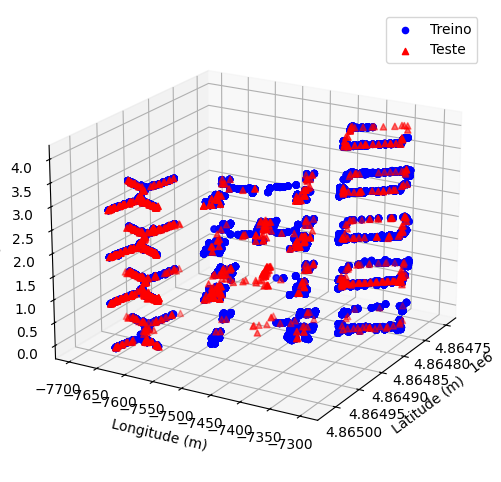

In [41]:
# Cria a figura 3D
fig1 = plt.figure(figsize=(10, 6))
ax = fig1.add_subplot(111, projection='3d')

# Plota os pontos de treino em azul
ax.scatter(data['LATITUDE'], data['LONGITUDE'], data['FLOOR'], c='blue', label='Treino', marker='o')

# Plota os pontos de teste em vermelho
ax.scatter(data_val['LATITUDE'], data_val['LONGITUDE'], data_val['FLOOR'], c='red', label='Teste', marker='^')

ax.view_init(elev=20, azim=30)  # Modifique esses valores conforme desejado

# Adiciona rótulos e legenda
ax.set_xlabel('Latitude (m)')
ax.set_ylabel('Longitude (m)')
ax.set_zlabel('Floor')
ax.legend()

#plt.title('Mapa 3D com Treino e Teste')
plt.show()


De outro ângulo

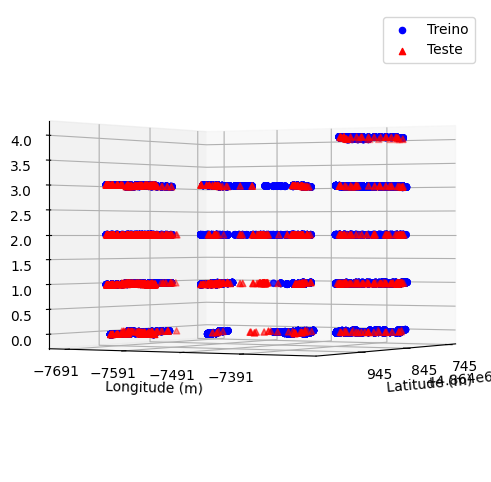

In [46]:
# Cria a figura 3D para conjunto de teste
fig2 = plt.figure(figsize=(10, 6))
ax = fig2.add_subplot(111, projection='3d')

# Plota os pontos de treino em azul
ax.scatter(data['LATITUDE'], data['LONGITUDE'], data['FLOOR'], c='blue', label='Treino', marker='o')

# Plota os pontos de teste em vermelho
ax.scatter(data_val['LATITUDE'], data_val['LONGITUDE'], data_val['FLOOR'], c='red', label='Teste', marker='^')

ax.view_init(elev=0, azim=30)  # Modifique esses valores conforme desejado

# Adiciona rótulos e legenda
ax.set_xlabel('Latitude (m)')
ax.set_ylabel('Longitude (m)')
ax.set_zlabel('Floor')
ax.legend()

# Ajusta as escalas dos eixos e define os intervalos desejados
ax.set_xticks(range(int(min(data['LATITUDE'])), int(max(data['LATITUDE'])) + 1, 100))
ax.set_yticks(range(int(min(data['LONGITUDE'])), int(max(data['LONGITUDE'])) + 1, 100))


#plt.title('Mapa 3D com Treino e Teste')
plt.show()

### 1.3 Variação da intensidade do sinal para diferentes WAPs nas longitudes e latitudes

Intensidade do WAP vs posição

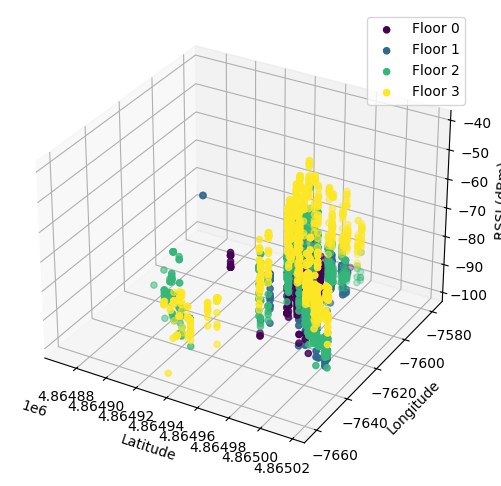

In [50]:
fig3 = plt.figure(figsize=(15, 6))
ax = fig3.add_subplot(111, projection='3d')

df = data[data.WAP052 != 100]

# Cores padrão da biblioteca matplotlib
cores = plt.cm.viridis(df['FLOOR'] / df['FLOOR'].max())

# Plota os pontos usando as cores convertidas
for floor_value in df['FLOOR'].unique():
    floor_subset = df[df['FLOOR'] == floor_value]
    ax.scatter(floor_subset['LATITUDE'], floor_subset['LONGITUDE'], floor_subset['WAP052'],
               c=cores[df['FLOOR'] == floor_value], marker='o', label=f'Floor {floor_value}')


# Adiciona a legenda no canto superior direito
ax.legend()

# Adiciona rótulos
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_zlabel('RSSI (dBm)')

#plt.title('Mapa 3D com Intensidade do Sinal (WAP052)')
plt.show()

Para outro WAP

In [ ]:
fig3 = plt.figure(figsize=(12, 6))
ax = fig3.add_subplot(111, projection='3d')

df = data[data.WAP072 != 100]

# Cores padrão da biblioteca matplotlib
cores = plt.cm.viridis(df['FLOOR'] / df['FLOOR'].max())

# Plota os pontos usando as cores convertidas
for floor_value in df['FLOOR'].unique():
    floor_subset = df[df['FLOOR'] == floor_value]
    ax.scatter(floor_subset['LATITUDE'], floor_subset['LONGITUDE'], floor_subset['WAP072'],
               c=cores[df['FLOOR'] == floor_value], marker='o', label=f'Floor {floor_value}')


# Adiciona a legenda no canto superior direito
ax.legend()

# Adiciona rótulos
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_zlabel('WAP072')

plt.title('Mapa 3D com Intensidade do Sinal (WAP072)')
plt.show()

## 2. Análise dos Parâmetros do Sistema

Vamos analisar como o sistema se comporta dada a escolha de número mínimo de WAPs por amostra, Nível mínimo de intensidade de sinal considerada, critério de seleção de atributos além de construir uma consideração sobre a implicação da atenuação dos aparelhos no erro do sistemas sobre um KNN simples.

### 2.1 Análise por algorítimo de seleção de abributo

Primeiramente, adicionamos uma coluna intervalar com os intervalos de 2 em 2 horas começando das 7 AM até 8 PM.

In [13]:
# Converte a coluna 'TIMESTAMP' para o formato de data
data['TIMESTAMP'] = pd.to_datetime(data['TIMESTAMP'], unit='s')

# Define os intervalos de 2 horas
# intervals = pd.date_range(start='07:00:00', end='19:00:00', freq='2H')
intervals = [x for x in range(6, 20, 2)]

labels = [f't{i}' for i in range(1, len(intervals))]
# labels = ['(7-9]', '(9-11]', '(11-13]', '(13-15]', '(15-17]']

# Adiciona uma coluna 'TIME_INTERVAL' ao dataframe, representando os intervalos de 2 horas
data['TIME_INTERVAL'] = pd.cut(data['TIMESTAMP'].dt.hour, bins=intervals, include_lowest=True, labels=labels)

# Mostra as primeiras linhas do dataframe resultante
# print(data.head())


Precisamos mudar o valor de 100 das amostras do dataset

In [14]:
data_new = data.copy()

data_new.iloc[:, 0:520] = data_new.iloc[:, 0:520].replace(100, np.nan)

Função para condição de média e desvio padrão

In [15]:
# Substitui os valores WAP dentro do critério definido
def replace_values(df_group):
    # Seleciona apenas as colunas de WAP (1-520)
    wap_columns = df_group.columns[0:520]
    
    # Calcula a média e o desvio padrão apenas nas colunas de WAP
    mean = df_group[wap_columns].mean(axis=0)
    std = df_group[wap_columns].std(axis=0)

    data_info = pd.concat([mean, std], axis=1)

    # Substituir os valores nas colunas do dataframe2
    for _, row in data_info.iterrows():
        coluna = row.name  
        media = row.iloc[0]  
        desvio_padrao = row.iloc[1]

        if media < -85 or desvio_padrao > 5:
            df_group[coluna] = -110

    return df_group, data_info

Agora, realizamos o algorítimo de seleção do mínimo valor de RSSI com base na média e no desvio padrão (estabilidade).

In [16]:
# Itera sobre cada grupo de ['SPACEID', 'PHONEID', 'TIME_INTERVAL']
for group_key, group_data in data_new.groupby(['SPACEID', 'PHONEID', 'TIME_INTERVAL'],observed=True):
    # Aplica a função de substituição para cada grupo
    modified_group, data_info = replace_values(group_data)
    
    # Concatena o resultado ao DataFrame final
    data_new.update(modified_group)


In [17]:
data_new.iloc[:, 0:520] = data_new.iloc[:, 0:520].replace(np.nan,-110)

Vejamos como se comporta o banco em relação a perda de informação

In [9]:
antes = (data_new['WAP052'] != -110).value_counts()
print(antes)
depois = (data['WAP052'] != 100).value_counts()
print(depois)

WAP052
False    18022
True      1074
Name: count, dtype: int64
WAP052
False    16920
True      2176
Name: count, dtype: int64


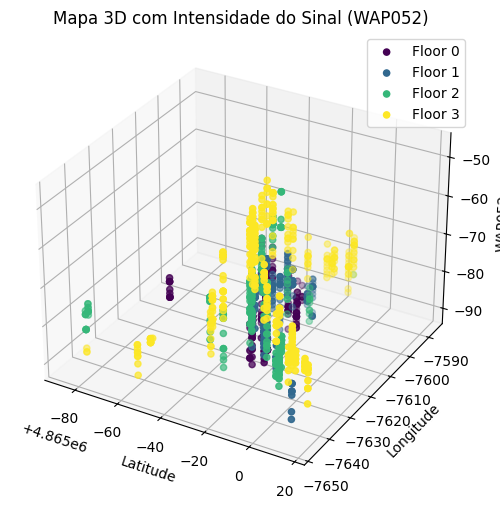

In [10]:
fig3 = plt.figure(figsize=(12, 6))
ax = fig3.add_subplot(111, projection='3d')

df = data_new[data_new.WAP052 != -110]

# Cores padrão da biblioteca matplotlib
cores = plt.cm.viridis(df['FLOOR'] / df['FLOOR'].max())

# Plota os pontos usando as cores convertidas
for floor_value in df['FLOOR'].unique():
    floor_subset = df[df['FLOOR'] == floor_value]
    ax.scatter(floor_subset['LATITUDE'], floor_subset['LONGITUDE'], floor_subset['WAP052'],
               c=cores[df['FLOOR'] == floor_value], marker='o', label=f'Floor {floor_value}')


# Adiciona a legenda no canto superior direito
ax.legend()

#ax.view_init(elev=20, azim=30)  # Modifique esses valores conforme desejado

# Adiciona rótulos
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_zlabel('WAP052')

plt.title('Mapa 3D com Intensidade do Sinal (WAP052)')
plt.show()

Preparação dos dados

In [18]:
# Used to remove columns where information is missing the validation data.
drop_columns =["SPACEID" ,"TIME_INTERVAL"]

data_new.drop(columns=drop_columns, inplace=True)

# Split training data from labels
X_new = data_new.iloc[:, :N]
Y_new = data_new.iloc[:, N:]

# Normalize data between 0 and 1 where 1 is strong signal and 0 is null
X_new /= min(X_new)
X_new = 1 - X_new

Vamos ver como se comporta quando reduzimos o número de WAPs para 20, selecionando os 20 melhores.

Como as saídas são multivariada, vamos propor fazer a seleção em parcelas. Para isso, aplicaremos a seleção sobre duas amostras,  de maneira independente e dependente.

Para a amostra dependente, temos:

In [24]:
knn_clf = KNeighborsClassifier(n_neighbors=3, weights='uniform', algorithm='kd_tree', leaf_size=50, p=2)

selector1 = SelectKBest(mutual_info_classif, k=400)
X_reduced_1 = selector1.fit_transform(X_new, Y_new['FLOOR'])

selector2 = SelectKBest(mutual_info_classif, k=300)
X_reduced_2 = selector2.fit_transform(X_reduced_1, Y_new['BUILDINGID'])

Aplicando o KNN sobre um conjunto dependente, conseguimos a seguinte acurácia:

In [28]:
## Split systems into train and test data sets
X20_train, X20_val, y20_train, y20_val = train_test_split(X_reduced_2, Y_new.values, test_size=0.2, random_state=0)

y20_train = DataFrame(y20_train, columns=Y_new.columns)
y20_val = DataFrame(y20_val, columns=Y_new.columns)

y20_train['FLOOR'] = pd.to_numeric(y20_train['FLOOR'], errors='coerce')
y20_val['FLOOR'] = pd.to_numeric(y20_val['FLOOR'], errors='coerce')
y20_train['BUILDINGID'] = pd.to_numeric(y20_train['BUILDINGID'], errors='coerce')
y20_val['BUILDINGID'] = pd.to_numeric(y20_val['BUILDINGID'], errors='coerce')

fit = knn_clf.fit(X20_train, y20_train[CATEGORICAL_COLUMNS])
prediction_clf = fit.predict(X20_val)
clf_prediction = DataFrame(prediction_clf, columns=[CATEGORICAL_COLUMNS])

# Armazena o valor de acurácia para cada n
acc_score1 = accuracy_score(y20_val['FLOOR'].values, prediction_clf[:,0])
acc_score2 = accuracy_score(y20_val['BUILDINGID'].values, prediction_clf[:,1])

print("Acurácia atributo Floor: ",round(acc_score1*100,2),"%")
print("Acurácia atributo Building: ",round(acc_score2*100,2),"%")

Acurácia atributo Floor:  93.27 %
Acurácia atributo Building:  96.86 %


Para a amostra independente, temos:

In [26]:
knn_clf = KNeighborsClassifier(n_neighbors=3, weights='uniform', algorithm='kd_tree', leaf_size=50, p=2)

selector1 = SelectKBest(mutual_info_classif, k=300)
X_reduced_1i = selector1.fit_transform(X_new, Y_new['FLOOR'])

selector2 = SelectKBest(mutual_info_classif, k=300)
X_reduced_2i = selector2.fit_transform(X_new, Y_new['BUILDINGID'])

Com isso, encontramos a seguinte acurácia:

In [29]:
## Split systems into train and test data sets
X20_train1i, X20_val1i, y20_train1i, y20_val1i = train_test_split(X_reduced_1i, Y_new.values, test_size=0.2, random_state=0)

y20_train1i = DataFrame(y20_train1i, columns=Y_new.columns)
y20_val1i = DataFrame(y20_val1i, columns=Y_new.columns)

y20_train1i['FLOOR'] = pd.to_numeric(y20_train1i['FLOOR'], errors='coerce')
y20_val1i['FLOOR'] = pd.to_numeric(y20_val1i['FLOOR'], errors='coerce')

fit = knn_clf.fit(X20_train1i, y20_train1i['FLOOR'])
prediction_clf1i = fit.predict(X20_val1i)
clf_prediction1i = DataFrame(prediction_clf1i, columns=['FLOOR'])

## Split systems into train and test data sets
X20_train2i, X20_val2i, y20_train2i, y20_val2i = train_test_split(X_reduced_2i, Y_new.values, test_size=0.2, random_state=0)

y20_train2i = DataFrame(y20_train2i, columns=Y_new.columns)
y20_val2i = DataFrame(y20_val2i, columns=Y_new.columns)

y20_train2i['BUILDINGID'] = pd.to_numeric(y20_train2i['BUILDINGID'], errors='coerce')
y20_val2i['BUILDINGID'] = pd.to_numeric(y20_val2i['BUILDINGID'], errors='coerce')

fit = knn_clf.fit(X20_train2i, y20_train2i['BUILDINGID'])
prediction_clf2i = fit.predict(X20_val2i)
clf_prediction2i = DataFrame(prediction_clf2i, columns=['BUILDINGID'])

# Armazena o valor de acurácia para cada n
acc_score1 = accuracy_score(y20_val1i['FLOOR'].values, prediction_clf1i)
acc_score2 = accuracy_score(y20_val2i['BUILDINGID'].values, prediction_clf2i)

print("Acurácia atributo Floor: ",round(acc_score1*100,2),"%")
print("Acurácia atributo Building: ",round(acc_score2*100,2),"%")

Acurácia atributo Floor:  93.19 %
Acurácia atributo Building:  96.94 %


Vamos verificar como se comporta a acurácia de um classificador KNN  com 3-folds para a variável Floor ao variar o número mínimo de WAP.

In [19]:
score_filter_clf = []
knn_clf = KNeighborsClassifier(n_neighbors=3, weights='uniform', algorithm='kd_tree', leaf_size=50, p=2)

for n in range(10, 110, 10):

    ## Seleciona os n melhores WAPs
    selector = SelectKBest(mutual_info_classif, k=n)
    X_reduced = selector.fit_transform(X_new, Y_new['FLOOR'])

    ## Split systems into train and test data sets
    Xn_train, Xn_val, yn_train, yn_val = train_test_split(X_reduced, Y_new.values, test_size=0.2, random_state=0)

    yn_train = DataFrame(yn_train, columns=Y_new.columns)
    yn_val = DataFrame(yn_val, columns=Y_new.columns)

    yn_train['FLOOR'] = pd.to_numeric(yn_train['FLOOR'], errors='coerce')
    yn_val['FLOOR'] = pd.to_numeric(yn_val['FLOOR'], errors='coerce')

    ## Fit e predict sobre o conjunto reduzido
    fit = knn_clf.fit(Xn_train, yn_train['FLOOR'])
    prediction_clf = fit.predict(Xn_val)
    clf_prediction = DataFrame(prediction_clf, columns=['FLOOR'])

    # Armazena o valor de acurácia para cada n
    acc_score = accuracy_score(yn_val["FLOOR"].values, prediction_clf)
    score_filter_clf.append(acc_score) 

Com isso, o resultado ao variarmos a quantidade de WAPs indica que até 100 WAPs a precisão aumenta linearmente com o crescimento do número de WAPs utilizados.

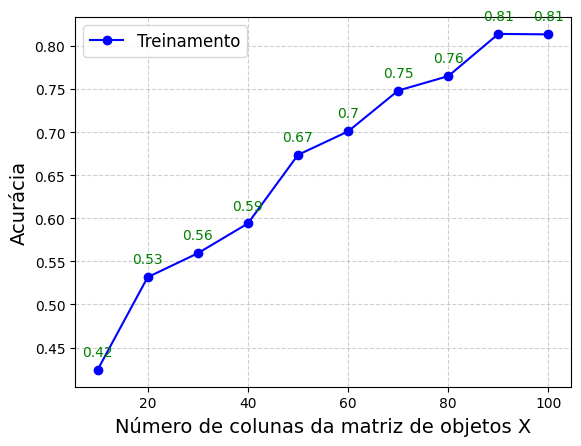

In [22]:
k_selector = list(range(10, 110, 10))  # Vetor de 3 a 30 com passo de 4

# Plotar o gráfico de dispersão
plt.plot(k_selector, score_filter_clf, marker='o', linestyle='-', color='b', label='Treinamento')

# Adicionar rótulos e título
plt.ylabel('Acurácia', fontsize=14)
plt.xlabel('Número de colunas da matriz de objetos X', fontsize=14)
#plt.title('Gráfico de Dispersão de Y sobre X')

# Adicionar grade para melhor visualização
plt.grid(True, linestyle='--', alpha=0.6)

# Adicionar legenda
plt.legend(fontsize=12)

# Adicionar anotações aos pontos
for i, (x, y) in enumerate(zip(k_selector, score_filter_clf)):
    plt.annotate(round(score_filter_clf[i],2), (x, y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=10, color='green')

# Exibir o gráfico
plt.show()

In [23]:
score_filter_clf_100 = []
knn_clf = KNeighborsClassifier(n_neighbors=3, weights='uniform', algorithm='kd_tree', leaf_size=50, p=2)

for n in range(100, 510, 100):

    ## Seleciona os n melhores WAPs
    selector = SelectKBest(mutual_info_classif, k=n)
    X_reduced = selector.fit_transform(X_new, Y_new['FLOOR'])

    ## Split systems into train and test data sets
    Xn_train, Xn_val, yn_train, yn_val = train_test_split(X_reduced, Y_new.values, test_size=0.2, random_state=0)

    yn_train = DataFrame(yn_train, columns=Y_new.columns)
    yn_val = DataFrame(yn_val, columns=Y_new.columns)

    yn_train['FLOOR'] = pd.to_numeric(yn_train['FLOOR'], errors='coerce')
    yn_val['FLOOR'] = pd.to_numeric(yn_val['FLOOR'], errors='coerce')

    ## Fit e predict sobre o conjunto reduzido
    fit = knn_clf.fit(Xn_train, yn_train['FLOOR'])
    prediction_clf = fit.predict(Xn_val)
    clf_prediction = DataFrame(prediction_clf, columns=['FLOOR'])

    # Armazena o valor de acurácia para cada n
    acc_score = accuracy_score(yn_val["FLOOR"].values, prediction_clf)
    score_filter_clf_100.append(acc_score) 

Aumentando a escala do gráfico, percebemos que a acurácia do preditor começa a ter uma saturação quando o número de WAPs atinge 300

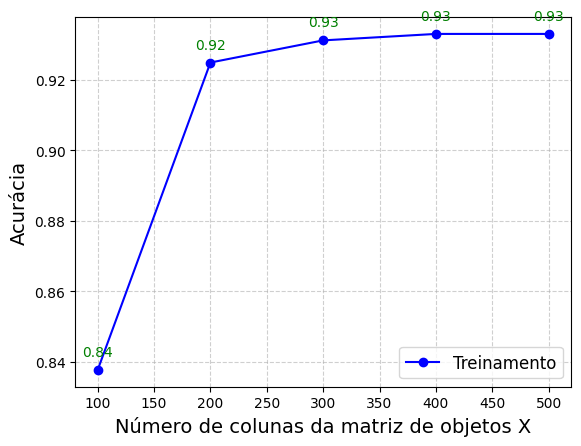

In [24]:
k_selector = list(range(100, 510, 100))  # Vetor de 3 a 30 com passo de 4

# Plotar o gráfico de dispersão
plt.plot(k_selector, score_filter_clf_100, marker='o', linestyle='-', color='b', label='Treinamento')

# Adicionar rótulos e título
plt.ylabel('Acurácia', fontsize=14)
plt.xlabel('Número de colunas da matriz de objetos X', fontsize=14)
#plt.title('Gráfico de Dispersão de Y sobre X')

# Adicionar grade para melhor visualização
plt.grid(True, linestyle='--', alpha=0.6)

# Adicionar legenda
plt.legend(fontsize=12)

# Adicionar anotações aos pontos
for i, (x, y) in enumerate(zip(k_selector, score_filter_clf_100)):
    plt.annotate(round(score_filter_clf_100[i],2), (x, y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=10, color='green')

# Exibir o gráfico
plt.show()

Perfomance do KNN para variação de min WAPs não nulos como critério de seleção sobre a base com tratamento de média e desvio padrão.

In [60]:
error_reg_min_wap = []
knn_reg = KNeighborsRegressor(n_neighbors=3, weights='uniform', algorithm='kd_tree', leaf_size=50, p=2)

for n in range(0, 21, 2):
    # Remove samples that have less than MIN_WAPS active WAPs 
    X_new_f, y_new_f = filter_out_low_WAPS(X_new, Y_new, n)

    y_new_f = DataFrame(y_new_f, columns=Y_new.columns)

    Xmin_train, Xmin_val, ymin_train, ymin_val = train_test_split(X_new_f, y_new_f.values, test_size=0.2, random_state=0)

    ymin_train = DataFrame(ymin_train, columns=Y_new.columns)
    ymin_val = DataFrame(ymin_val, columns=Y_new.columns)

    ## Fit e predict sobre o conjunto reduzido
    fit = knn_reg.fit(Xmin_train, ymin_train[QUANTITATIVE_COLUMNS])
    prediction_reg = fit.predict(Xmin_val)
    reg_prediction = DataFrame(prediction_reg, columns=QUANTITATIVE_COLUMNS)

    # Convertendo dados para cálculo
    reg_prediction['LONGITUDE'] = pd.to_numeric(reg_prediction['LONGITUDE'], errors='coerce')
    reg_prediction['LATITUDE'] = pd.to_numeric(reg_prediction['LATITUDE'], errors='coerce')
    ymin_val['LATITUDE'] = pd.to_numeric(ymin_val['LATITUDE'], errors='coerce')
    ymin_val['LONGITUDE'] = pd.to_numeric(ymin_val['LONGITUDE'], errors='coerce')

    # Calcula o erro
    coords_error = localizaion_error(reg_prediction, ymin_val)
    error_reg_min_wap.append(np.mean(coords_error))

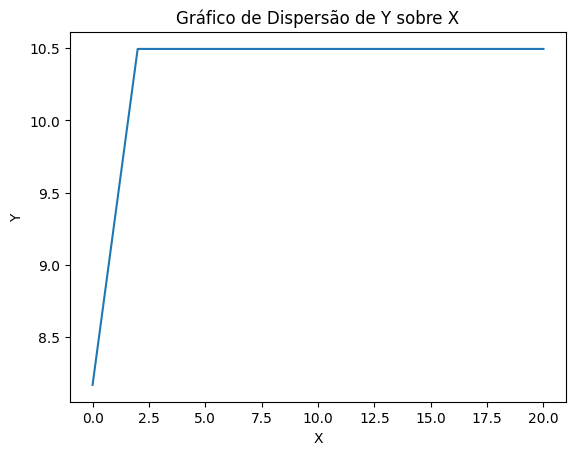

In [62]:
k_min_wap = list(range(0, 21, 2))  # Vetor de 3 a 30 com passo de 4

# Plotar o gráfico de dispersão
plt.plot(k_min_wap, error_reg_min_wap, label='Dados Y sobre X')

# Adicionar rótulos e título
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Gráfico de Dispersão de Y sobre X')

# Exibir o gráfico
plt.show()

Sobre a base normal

In [9]:
## Results form analysis:
MIN_WAPS = 9
SRC_NULL = 100 # Original Null Value
dst_null = -98 # Changed Null Value

# Change null value to new value and set all lower values to it.
X.replace(SRC_NULL, dst_null, inplace=True)
X[X < dst_null] = dst_null

X_teste.replace(SRC_NULL, dst_null, inplace=True)
X_teste[X_teste < dst_null] = dst_null

# Normalize data between 0 and 1 where 1 is strong signal and 0 is null
X /= min(X)
X = 1 - X

X_teste /= min(X_teste)
X_val = 1 - X_teste

In [64]:
error_reg_analise = []
clf = KNeighborsRegressor(n_neighbors=5, weights='distance', algorithm='kd_tree', leaf_size=50, p=2)

for n in range(0, 21, 2):
    # Remove samples that have less than MIN_WAPS active WAPs 
    X_analise, y_analise = filter_out_low_WAPS(X, Y, n) 

    y_analise = DataFrame(y_analise, columns=Y.columns)

    ## Split systems into train and test data sets
    Xa_train, Xa_test, ya_train, ya_val = train_test_split(X_analise, y_analise.values, test_size=0.2, random_state=0)

    ya_train = DataFrame(ya_train, columns=Y.columns)
    ya_val = DataFrame(ya_val, columns=Y.columns)

    ## Fit e predict regressors
    fit = clf.fit(Xa_train, ya_train[QUANTITATIVE_COLUMNS])
    prediction_reg_analise = fit.predict(Xa_test)
    regr_prediction_analise = DataFrame(prediction_reg_analise, columns=QUANTITATIVE_COLUMNS)

    # Calcula o erro
    coords_error = localizaion_error(regr_prediction_analise, ya_val)
    error_reg_analise.append(np.mean(coords_error))

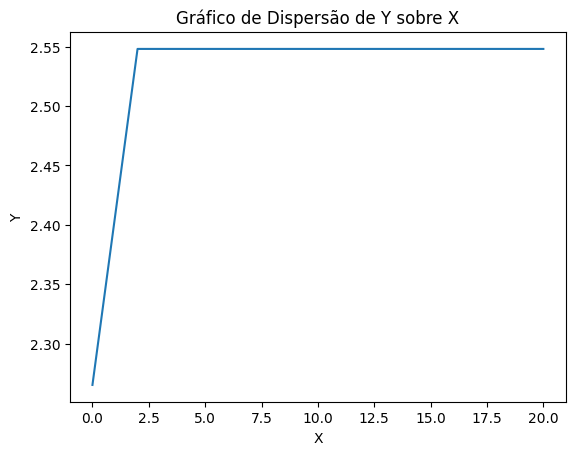

In [65]:
k_analise = list(range(0, 21, 2))  # Vetor de 3 a 30 com passo de 4

# Plotar o gráfico de dispersão
plt.plot(k_analise, error_reg_analise, label='Dados Y sobre X')

# Adicionar rótulos e título
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Gráfico de Dispersão de Y sobre X')

# Exibir o gráfico
plt.show()

Comparação do KNN com e sem abordagem de tempo e espaço 

## 3. Implementação dos Modelos e Parameter Tuning 

Nessa etapa vamos identificar os parâmetros desejados para os modelos utilizados. Podemos variar esses parâmetros conforme os resultados alcançados na etapa de teste.

Os modelos de regressão e classificação implementados serão KNN, Decision tree e Neural Network.


In [3]:
## Results form analysis:
MIN_WAPS = 9
SRC_NULL = 100 # Original Null Value
dst_null = -98 # Changed Null Value

# Change null value to new value and set all lower values to it.
X.replace(SRC_NULL, dst_null, inplace=True)
X[X < dst_null] = dst_null

X_teste.replace(SRC_NULL, dst_null, inplace=True)
X_teste[X_teste < dst_null] = dst_null

# Normalize data between 0 and 1 where 1 is strong signal and 0 is null
X /= min(X)
X = 1 - X

X_teste /= min(X_teste)
X_teste = 1 - X_teste


In [20]:
# Used to remove columns where information is missing the validation data.
drop_columns =["TIME_INTERVAL"]

data_new.drop(columns=drop_columns, inplace=True)

# Split training data from labels
X_new = data_new.iloc[:, :N]
Y_new = data_new.iloc[:, N:]

# Normalize data between 0 and 1 where 1 is strong signal and 0 is null
X_new /= min(X_new)
X_new = 1 - X_new


In [38]:
selector = SelectKBest(mutual_info_classif, k=300)
X_reduced_clf = selector.fit_transform(X_new, Y_new['FLOOR'])

selector = SelectKBest(mutual_info_regression, k=300)
X_reduced_reg = selector.fit_transform(X_new, Y_new['LONGITUDE'])

Vamos dividir o conjunto de treinamento entre treinamento e validação para analisar os hiperparâmetros

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, Y.values, test_size=0.2, random_state=0)

y_train = DataFrame(y_train, columns=Y.columns)
y_val = DataFrame(y_val, columns=Y.columns)

### 3.1 KNN

#### 3.1.1 Tuning Parameter

Inicialmente, vamos chamar os parâmetros dos modelos como variáveis e definir um modelo de validação cruzada estratificada com 10 folds.

In [10]:
## Estratificar
#n_folds = 10
#skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

## Chamar os modelos com variável nos parâmetros
ngb = [1,3,5,7]
wgt = ['uniform', 'distance']
pv = [1,2,3,4]

Vemos que o KNN tem um ponto ótimo para essa base quando realiza validação com 5 vizinhos mais próximos, entretando a variação percentual é muito pequena, de apenas $0,02\%$. Se levarmos em consideração o ganho computacional de realizar a operação com apenas 1 vizinho, já que será realizado apenas 1 cálculo de distância, a escolha de um K menor pode ser a mais coerente.

In [18]:
scores_clf_ngb_flr = []
scores_clf_ngb_build = []
scores_reg_ngb_lat = []
scores_reg_ngb_log = []

# Loop para variar os parâmetros
for neighbors in ngb:
    # Cria o KNN
    knn_clf = KNeighborsClassifier(n_neighbors=neighbors, weights='uniform', algorithm='kd_tree', leaf_size=50, p=2)
    knn_regr = KNeighborsRegressor(n_neighbors=neighbors, weights='uniform', algorithm='kd_tree', leaf_size=50, p=2)

    # Treinamento e validação
    ## Fit e predict classifier
    fit = knn_clf.fit(X_train, y_train[CATEGORICAL_COLUMNS])
    prediction_clf = fit.predict(X_val)
    fit = knn_regr.fit(X_train, y_train[QUANTITATIVE_COLUMNS])
    prediction_reg = fit.predict(X_val)

    # Calcula acurácia e erro
    acc_score1 = accuracy_score(y_val["FLOOR"].values, prediction_clf[:,0])
    acc_score2 = accuracy_score(y_val["BUILDINGID"], prediction_clf[:,1])

    mse_latitude = mean_squared_error(y_val["LATITUDE"].values, prediction_reg[:, 1])
    mse_longitude = mean_squared_error(y_val["LONGITUDE"].values, prediction_reg[:, 0])

    # Armazena as médias
    scores_clf_ngb_flr.append(acc_score1)
    scores_clf_ngb_build.append(acc_score2)
    scores_reg_ngb_lat.append(mse_latitude)
    scores_reg_ngb_log.append(mse_longitude)

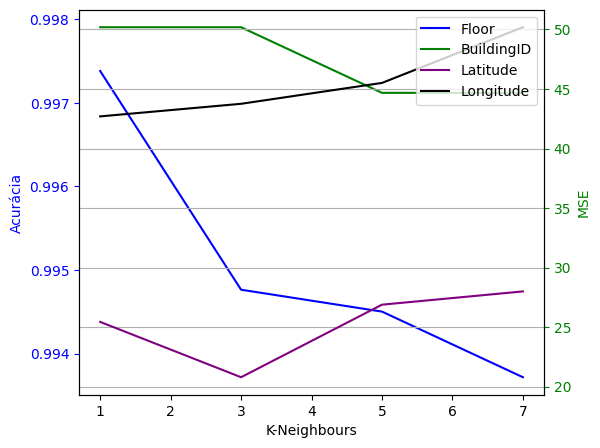

In [ ]:
# Criação do gráfico
fig, ax1 = plt.subplots(figsize=(6, 5))

# Plota y1 e y2 no primeiro eixo y
ax1.plot(ngb, scores_clf_ngb_flr, label='Floor', color='blue')
ax1.plot(ngb, scores_clf_ngb_build, label='BuildingID', color='Green')
ax1.set_xlabel('K-Neighbours')
ax1.set_ylabel('Acurácia', color='blue')
ax1.tick_params('y', colors='blue')

# Cria um segundo eixo y compartilhando o mesmo eixo x
ax2 = ax1.twinx()
ax2.plot(ngb, scores_reg_ngb_lat, label='Latitude', color='purple')
ax2.plot(ngb, scores_reg_ngb_log, label='Longitude', color='black')
ax2.set_ylabel('MSE', color='green')
ax2.tick_params('y', colors='green')

# Adiciona legenda
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

#plt.title('Gráfico de Linhas com Duas Escalas')
plt.grid()
plt.show()

Essa análise também pode ser feita com validação cruzada se necessário

In [ ]:
mean_scores_clf_ngb = []

# Loop para variar os parâmetros
for neighbors in ngb:
    # Cria o KNN
    knn_clf = KNeighborsClassifier(n_neighbors=neighbors, weights='uniform', algorithm='kd_tree', leaf_size=50, p=2)
    
    # Validação cruzada para classificação
    skf = StratifiedKFold(n_splits=10)
    scores_clf = cross_val_score(knn_clf, X, y['FLOOR'], cv=skf)
    
    # Calcula a média das pontuações
    mean_score_clf = np.mean(scores_clf)
    
    # Armazena as médias
    mean_scores_clf_ngb.append(mean_score_clf)
    
plt.plot(ngb, mean_scores_clf_ngb, label="Classificação")
plt.xlabel("Valor de K-Neighboors")
plt.ylabel("Média da Pontuação da Validação Cruzada")
plt.legend()
plt.show()

Com relação ao parâmetro de weight, que se refere a atribuição de um peso maior para vizinhos mais próximos na validação, isso só fará alguma diferença desde que K>1, e permitirá ao sistema ponderar a proximidade das amostras. O que pode ser visualizado na comparação abaixo:

In [31]:
scores_clf_wgt_flr = []
scores_clf_wgt_build = []
scores_reg_wgt_lat = []
scores_reg_wgt_log = []

# Loop para variar os parâmetros
for weight in wgt:
    # Cria o KNN
    knn_clf = KNeighborsClassifier(n_neighbors=3, weights= weight, algorithm='kd_tree', leaf_size=50, p=2)
    knn_regr = KNeighborsRegressor(n_neighbors=3, weights= weight, algorithm='kd_tree', leaf_size=50, p=2)

    # Treinamento e validação
    ## Fit e predict classifier
    fit = knn_clf.fit(X_train, y_train[CATEGORICAL_COLUMNS])
    prediction_clf = fit.predict(X_val)
    fit = knn_regr.fit(X_train, y_train[QUANTITATIVE_COLUMNS])
    prediction_reg = fit.predict(X_val)

    # Calcula acurácia e erro
    acc_score1 = accuracy_score(y_val["FLOOR"].values, prediction_clf[:,0])
    acc_score2 = accuracy_score(y_val["BUILDINGID"], prediction_clf[:,1])

    mse_latitude = mean_squared_error(y_val["LATITUDE"].values, prediction_reg[:, 1])
    mse_longitude = mean_squared_error(y_val["LONGITUDE"].values, prediction_reg[:, 0])

    # Armazena as médias
    scores_clf_wgt_flr.append(acc_score1)
    scores_clf_wgt_build.append(acc_score2)
    scores_reg_wgt_lat.append(mse_latitude)
    scores_reg_wgt_log.append(mse_longitude)

In [ ]:
mean_scores_clf_wgt = []

# Loop para variar os parâmetros
for weight in wgt:
    # Cria o KNN
    knn_clf = KNeighborsClassifier(n_neighbors=3, weights=weight, algorithm='kd_tree', leaf_size=50, p=2)
    
    # Validação cruzada para classificação
    skf = StratifiedKFold(n_splits=10)
    scores_clf = cross_val_score(knn_clf, X, y['FLOOR'], cv=skf)
    
    # Calcula a média das pontuações
    mean_score_clf = np.mean(scores_clf)
    
    # Armazena as médias
    mean_scores_clf_wgt.append(mean_score_clf)
    
print("Média Acurácia Weight Uniforme:", mean_scores_clf_wgt[0])
print("\nMédia Acurácia Weight com Peso na Distância:", mean_scores_clf_wgt[1])

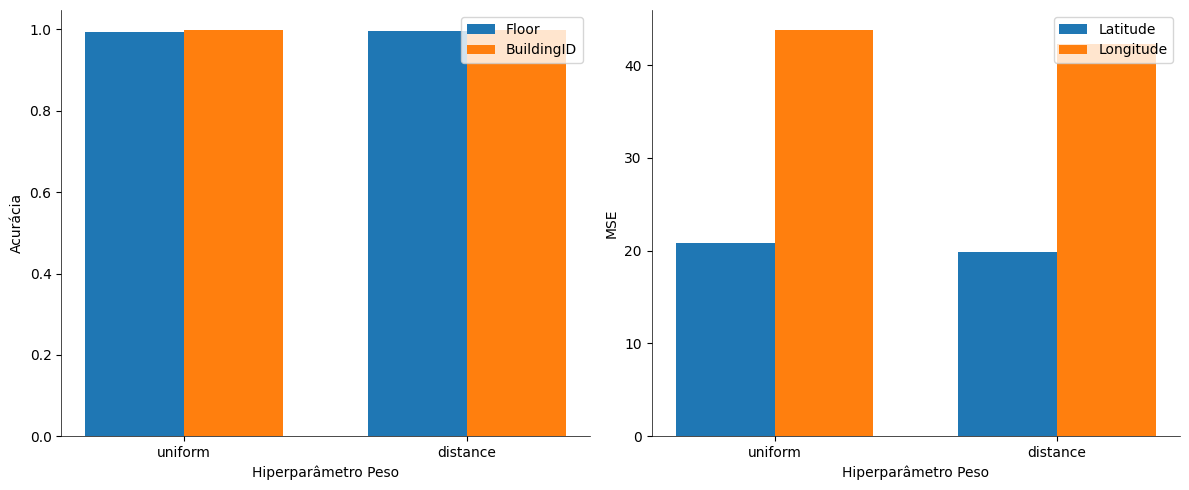

In [48]:
largura_barra = 0.35

# Criação dos gráficos de barras agrupadas
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Gráfico 1: y1 e y2
largura_barra = 0.35
posicoes1 = np.arange(len(wgt))
ax1.bar(posicoes1 - largura_barra/2, scores_clf_wgt_flr, largura_barra, label='Floor')
ax1.bar(posicoes1 + largura_barra/2, scores_clf_wgt_build, largura_barra, label='BuildingID')
ax1.set_xticks(posicoes1)
ax1.set_xticklabels(wgt)
ax1.set_xlabel('Hiperparâmetro Peso')
ax1.set_ylabel('Acurácia')
ax1.legend(loc='upper right')

# Remove as linhas de borda, mantendo apenas as linhas da escala
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_linewidth(0.5)
ax1.spines['left'].set_linewidth(0.5)

# Gráfico 2: y3 e y4 agrupados
posicoes2 = np.arange(len(wgt))
ax2.bar(posicoes2 - largura_barra/2, scores_reg_wgt_lat, largura_barra, label='Latitude')
ax2.bar(posicoes2 + largura_barra/2, scores_reg_wgt_log, largura_barra, label='Longitude')
ax2.set_xticks(posicoes2)
ax2.set_xticklabels(wgt)
ax2.set_xlabel('Hiperparâmetro Peso')
ax2.set_ylabel('MSE')
ax2.legend(loc='upper right')

# Remove as linhas de borda, mantendo apenas as linhas da escala
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_linewidth(0.5)
ax2.spines['left'].set_linewidth(0.5)

# Ajusta o layout para evitar sobreposição
plt.tight_layout()

# Exibe os gráficos
plt.show()

#### 3.3.2 Cross Validation

Tendo isso em consideração, podemos verificar a performance do modelo dado os parâmetros K=5, weight = 'distance' e p = 2 com validação cruzada.

Essa validação será realizada sobre dois conjuntos: Conjunto original, filtrando amostras que não possuam a quantidade mínima de WAPs não nulos, e o conjunto adaptado ao problema de estabilidade e mínima intensidade do sinal.

Primeiro vejamos a estatística do erro:

##### ESTATISTICA CLASSIFICAÇÃO:

In [107]:
knn_clf = KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='kd_tree', leaf_size=50, p=2)
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
skf_flr_c1 = cross_validate(knn_clf, X, Y['FLOOR'], cv=stratified_cv, scoring=('balanced_accuracy'))
skf_bld_c1 = cross_validate(knn_clf, X, Y['BUILDINGID'], cv=stratified_cv, scoring=('balanced_accuracy'))
skf_flr_c2 = cross_validate(knn_clf, X_reduced_clf, Y_new['FLOOR'], cv=stratified_cv, scoring=('balanced_accuracy'))
skf_bld_c2 = cross_validate(knn_clf, X_reduced_clf, Y_new['BUILDINGID'], cv=stratified_cv, scoring=('balanced_accuracy'))


In [109]:
estatistica_clf = {
    'Estatística': ['Maxima Acurácia','Minima Acurácia','Acurácia Média','Std Acurácia'],
    'Conjunto 1 Floor': [max(skf_flr_c1['test_score']), min(skf_flr_c1['test_score']), mean(skf_flr_c1['test_score']),stdev(skf_flr_c1['test_score'])],
    'Conjunto 2 Floor': [max(skf_flr_c2['test_score']), min(skf_flr_c2['test_score']), mean(skf_flr_c2['test_score']),stdev(skf_flr_c2['test_score'])],
    'Conjunto 1 Building': [max(skf_bld_c1['test_score']), min(skf_bld_c1['test_score']), mean(skf_bld_c1['test_score']),stdev(skf_bld_c1['test_score'])],
    'Conjunto 2 Building': [max(skf_bld_c2['test_score']), min(skf_bld_c2['test_score']), mean(skf_bld_c2['test_score']),stdev(skf_bld_c2['test_score'])]
}

df_stat_clf = pd.DataFrame(estatistica_clf)
display(df_stat_clf)

,Estatística,Conjunto 1 Floor,Conjunto 2 Floor,Conjunto 1 Building,Conjunto 2 Building
0,Maxima Acurácia,0.997482,0.939270,0.997832,0.971228
1,Minima Acurácia,0.994248,0.935372,0.995134,0.965510
2,Acurácia Média,0.996190,0.937968,0.997008,0.967884
3,Std Acurácia,0.001247,0.001533,0.001103,0.002526


In [121]:
## Results from Analysis:
## KNN
knn_clf = KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='kd_tree', leaf_size=50, p=2)

# Divide cada dataset
X_train, X_val, y_train, y_val = train_test_split(X, Y.values, test_size=0.2, random_state=0)
y_train = DataFrame(y_train, columns=Y.columns)
y_val = DataFrame(y_val, columns=Y.columns)

X_train_new, X_val_new, y_train_new, y_val_new = train_test_split(X_reduced_clf, Y_new.values, test_size=0.2, random_state=0)
y_train_new = DataFrame(y_train_new, columns=Y_new.columns)
y_val_new = DataFrame(y_val_new, columns=Y_new.columns)

y_train_new['FLOOR'] = pd.to_numeric(y_train_new['FLOOR'], errors='coerce')
y_val_new['FLOOR'] = pd.to_numeric(y_val_new['FLOOR'], errors='coerce')
y_train_new['BUILDINGID'] = pd.to_numeric(y_train_new['BUILDINGID'], errors='coerce')
y_val_new['BUILDINGID'] = pd.to_numeric(y_val_new['BUILDINGID'], errors='coerce')

#Fit e predict do modelo
fit = knn_clf.fit(X_train, y_train[CATEGORICAL_COLUMNS])
prediction_clf_c1 = fit.predict(X_val)
clf_prediction_c1 = DataFrame(prediction_clf_c1, columns=[CATEGORICAL_COLUMNS])

fit = knn_clf.fit(X_train_new, y_train_new[CATEGORICAL_COLUMNS])
prediction_clf_c2 = fit.predict(X_val_new)
clf_prediction_c2 = DataFrame(prediction_clf_c2, columns=[CATEGORICAL_COLUMNS])

#Matriz de confusão
cm_flr_c1 = confusion_matrix(y_val['FLOOR'], clf_prediction_c1['FLOOR'])
cm_flr_c2 = confusion_matrix(y_val_new['FLOOR'], clf_prediction_c2['FLOOR'])
cm_bld_c1 = confusion_matrix(y_val['BUILDINGID'], clf_prediction_c1['BUILDINGID'])
cm_bld_c2 = confusion_matrix(y_val_new['BUILDINGID'], clf_prediction_c2['BUILDINGID'])

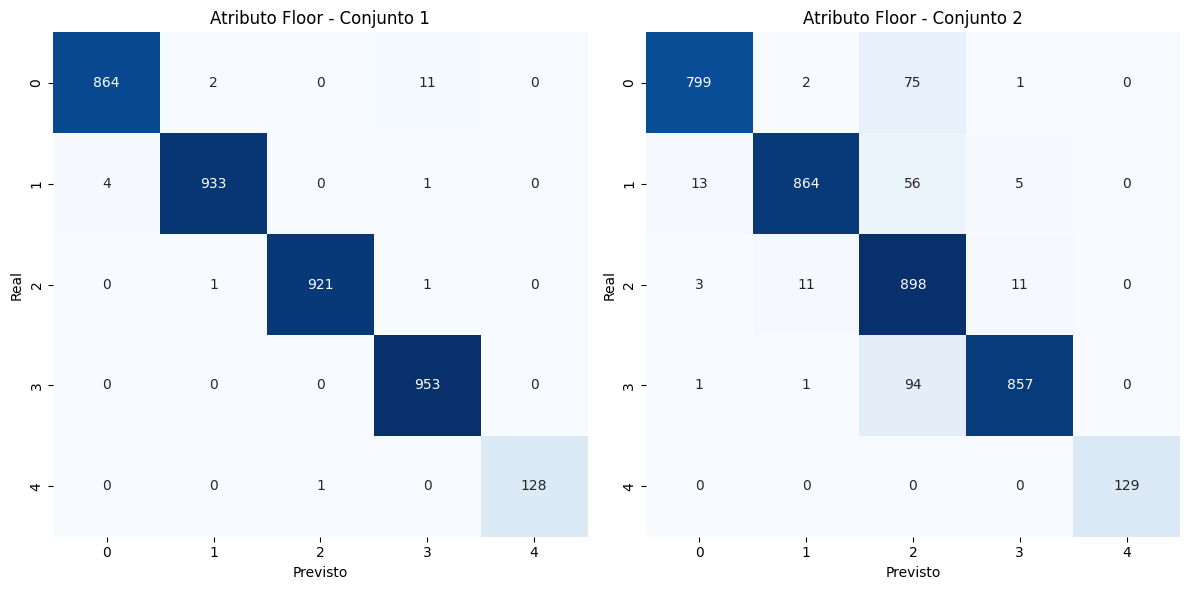

In [123]:
# Configuração do subplot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plotagem do heatmap para cm1
sns.heatmap(cm_flr_c1, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[0])
axes[0].set_title('Atributo Floor - Conjunto 1')
axes[0].set_xlabel('Previsto')
axes[0].set_ylabel('Real')

# Plotagem do heatmap para cm2
sns.heatmap(cm_flr_c2, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[1])
axes[1].set_title('Atributo Floor - Conjunto 2')
axes[1].set_xlabel('Previsto')
axes[1].set_ylabel('Real')

# Ajusta o layout
plt.tight_layout()
plt.show()

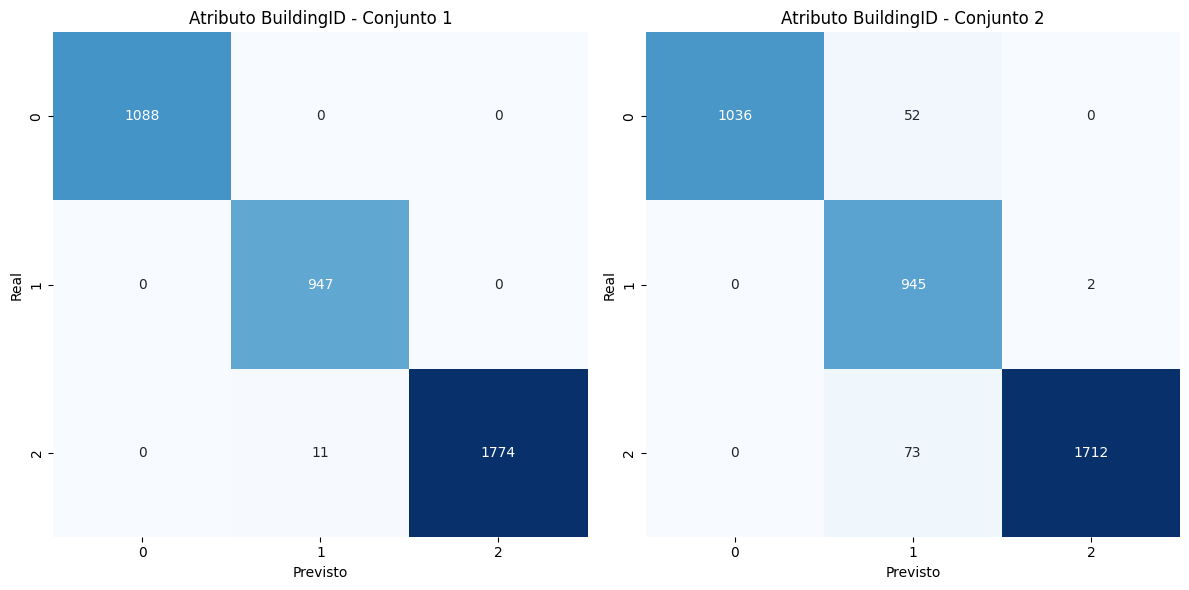

In [124]:
# Configuração do subplot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plotagem do heatmap para cm1
sns.heatmap(cm_bld_c1, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[0])
axes[0].set_title('Atributo BuildingID - Conjunto 1')
axes[0].set_xlabel('Previsto')
axes[0].set_ylabel('Real')

# Plotagem do heatmap para cm2
sns.heatmap(cm_bld_c2, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[1])
axes[1].set_title('Atributo BuildingID - Conjunto 2')
axes[1].set_xlabel('Previsto')
axes[1].set_ylabel('Real')

# Ajusta o layout
plt.tight_layout()
plt.show()

Alternativa:

In [40]:
## Results from Analysis:
## KNN

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

knn_clf = KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='kd_tree', leaf_size=50, p=2)
knn_regr = KNeighborsRegressor(n_neighbors=5, weights='distance', algorithm='kd_tree', leaf_size=50, p=2)

lst_accu_stratified_flr_c1 = []
lst_accu_stratified_bld_c1 = []
lst_accu_stratified_flr_c2 = []
lst_accu_stratified_bld_c2 = []
  
for train_index, val_index in skf.split(X, Y['FLOOR']):
    x_train_fold, x_val_fold = X.iloc[train_index], X.iloc[val_index]
    y_train_fold, y_val_fold = Y.iloc[train_index], Y.iloc[val_index]
    
    fit = knn_clf.fit(x_train_fold, y_train_fold[CATEGORICAL_COLUMNS])
    prediction_clf = fit.predict(x_val_fold)

    # Calcula acurácia e erro
    acc_score1 = accuracy_score(y_val_fold["FLOOR"].values, prediction_clf[:,0])
    acc_score2 = accuracy_score(y_val_fold["BUILDINGID"].values, prediction_clf[:,1])

    lst_accu_stratified_flr_c1.append(acc_score1)
    lst_accu_stratified_bld_c1.append(acc_score2)

for train_index, val_index in skf.split(X_reduced_clf, Y_new['FLOOR']):
    x_train_fold, x_val_fold = X_reduced_clf[train_index], X_reduced_clf[val_index]
    y_train_fold, y_val_fold = Y_new.iloc[train_index], Y_new.iloc[val_index]
    
    fit = knn_clf.fit(x_train_fold, y_train_fold[CATEGORICAL_COLUMNS])
    prediction_clf = fit.predict(x_val_fold)

    # Calcula acurácia e erro
    acc_score1 = accuracy_score(y_val_fold["FLOOR"].values, prediction_clf[:,0])
    acc_score2 = accuracy_score(y_val_fold["BUILDINGID"].values, prediction_clf[:,1])

    lst_accu_stratified_flr_c2.append(acc_score1)
    lst_accu_stratified_bld_c2.append(acc_score2)


In [95]:
# Print the output.
print('List of possible accuracy:', lst_accu_stratified_flr_c2)
print('\nMaximum Accuracy That can be obtained from this model is:',
      max(lst_accu_stratified_flr_c2)*100, '%')
print('\nMinimum Accuracy:',
      min(lst_accu_stratified_flr_c2)*100, '%')
print('\nOverall Accuracy:',
      mean(lst_accu_stratified_flr_c2)*100, '%')
print('\nStandard Deviation is:', stdev(lst_accu_stratified_flr_c2))

print('\nList of possible accuracy:', lst_accu_stratified_bld_c2)
print('\nMaximum Accuracy That can be obtained from this model is:',
      max(lst_accu_stratified_bld_c2)*100, '%')
print('\nMinimum Accuracy:',
      min(lst_accu_stratified_bld_c2)*100, '%')
print('\nOverall Accuracy:',
      mean(lst_accu_stratified_bld_c2)*100, '%')
print('\nStandard Deviation is:', stdev(lst_accu_stratified_bld_c2))

List of possible accuracy: [0.9242852654728244, 0.9223880597014925, 0.9200314218381775]

Maximum Accuracy That can be obtained from this model is: 92.42852654728244 %

Minimum Accuracy: 92.00314218381776 %

Overall Accuracy: 92.22349156708314 %

Standard Deviation is: 0.0021310528472099776

List of possible accuracy: [0.9666980835689601, 0.9668499607227022, 0.9622937941869599]

Maximum Accuracy That can be obtained from this model is: 96.68499607227022 %

Minimum Accuracy: 96.229379418696 %

Overall Accuracy: 96.52806128262074 %

Standard Deviation is: 0.0025877752714009877


In [94]:
# Print the output.
print('List of possible accuracy:', lst_accu_stratified_flr_c1)
print('\nMaximum Accuracy That can be obtained from this model is:',
      max(lst_accu_stratified_flr_c1)*100, '%')
print('\nMinimum Accuracy:',
      min(lst_accu_stratified_flr_c1)*100, '%')
print('\nOverall Accuracy:',
      mean(lst_accu_stratified_flr_c1)*100, '%')
print('\nStandard Deviation is:', stdev(lst_accu_stratified_flr_c1))

print('\nList of possible accuracy:', lst_accu_stratified_bld_c1)
print('\nMaximum Accuracy That can be obtained from this model is:',
      max(lst_accu_stratified_bld_c1)*100, '%')
print('\nMinimum Accuracy:',
      min(lst_accu_stratified_bld_c1)*100, '%')
print('\nOverall Accuracy:',
      mean(lst_accu_stratified_bld_c1)*100, '%')
print('\nStandard Deviation is:', stdev(lst_accu_stratified_bld_c1))

List of possible accuracy: [0.9960728872133208, 0.9959151610369207, 0.996229379418696]

Maximum Accuracy That can be obtained from this model is: 99.62293794186961 %

Minimum Accuracy: 99.59151610369207 %

Overall Accuracy: 99.60724758896458 %

Standard Deviation is: 0.00015710959471577996

List of possible accuracy: [0.9974866478165253, 0.998114689709348, 0.9978004713275727]

Maximum Accuracy That can be obtained from this model is: 99.8114689709348 %

Minimum Accuracy: 99.74866478165254 %

Overall Accuracy: 99.78006029511486 %

Standard Deviation is: 0.0003140209671003883


##### ESTATÍSTICAS REGRESSÃO:

In [125]:
knn_regr = KNeighborsRegressor(n_neighbors=5, weights='distance', algorithm='kd_tree', leaf_size=50, p=2)
skf_lat_c1 = cross_validate(knn_regr, X, Y['LATITUDE'], cv=5, scoring=('r2', 'neg_mean_squared_error'))
skf_log_c1 = cross_validate(knn_regr, X, Y['LONGITUDE'], cv=5, scoring=('r2', 'neg_mean_squared_error'))
skf_lat_c2 = cross_validate(knn_regr, X_reduced_reg, Y_new['LATITUDE'], cv=5, scoring=('r2', 'neg_mean_squared_error'))
skf_log_c2 = cross_validate(knn_regr, X_reduced_reg, Y_new['LONGITUDE'], cv=5, scoring=('r2', 'neg_mean_squared_error'))


In [126]:
estatistica_reg = {
    'Estatística': ['Maximo MSE','Minimo MSE','MSE Médio','Std MSE','Maximo r2','Minimo r2','r2 Médio','Std r2'],
    'Conjunto 1 Latitude (m)': [max(skf_lat_c1['test_neg_mean_squared_error']), min(skf_lat_c1['test_neg_mean_squared_error']), mean(skf_lat_c1['test_neg_mean_squared_error']),stdev(skf_lat_c1['test_neg_mean_squared_error']),max(skf_lat_c1['test_r2']), min(skf_lat_c1['test_r2']), mean(skf_lat_c1['test_r2']),stdev(skf_lat_c1['test_r2'])],
    'Conjunto 2 Latitude (m)': [max(skf_lat_c2['test_neg_mean_squared_error']), min(skf_lat_c2['test_neg_mean_squared_error']), mean(skf_lat_c2['test_neg_mean_squared_error']),stdev(skf_lat_c2['test_neg_mean_squared_error']),max(skf_lat_c2['test_r2']), min(skf_lat_c2['test_r2']), mean(skf_lat_c2['test_r2']),stdev(skf_lat_c2['test_r2'])],
    'Conjunto 1 Longitude (m)': [max(skf_log_c1['test_neg_mean_squared_error']), min(skf_log_c1['test_neg_mean_squared_error']), mean(skf_log_c1['test_neg_mean_squared_error']),stdev(skf_log_c1['test_neg_mean_squared_error']),max(skf_log_c1['test_r2']), min(skf_log_c1['test_r2']), mean(skf_log_c1['test_r2']),stdev(skf_log_c1['test_r2'])],
    'Conjunto 2 Longitude (m)': [max(skf_log_c2['test_neg_mean_squared_error']), min(skf_log_c2['test_neg_mean_squared_error']), mean(skf_log_c2['test_neg_mean_squared_error']),stdev(skf_log_c2['test_neg_mean_squared_error']),max(skf_log_c2['test_r2']), min(skf_log_c2['test_r2']), mean(skf_log_c2['test_r2']),stdev(skf_log_c2['test_r2'])]
}

df_stat_reg = pd.DataFrame(estatistica_reg)
display(df_stat_reg)

,Estatística,Conjunto 1 Latitude (m),Conjunto 2 Latitude (m),Conjunto 1 Longitude (m),Conjunto 2 Longitude (m)
0,Maximo MSE,-23.658423,-176.465374,-53.301295,-317.856969
1,Minimo MSE,-904.668441,-1420.848270,-1486.399589,-1888.675345
2,MSE Médio,-236.614765,-776.692808,-426.371359,-1467.143567
3,Std MSE,377.013982,453.443921,603.909455,655.675551
4,Maximo r2,0.994275,0.936844,0.996914,0.968781
5,Minimo r2,0.643722,0.440440,0.694250,0.657492
6,r2 Médio,0.909871,0.741665,0.926508,0.837711
7,Std r2,0.150358,0.197145,0.130695,0.123686


O erro de localização será, para cada conjunto de dados:

In [53]:
## Results from Analysis:
## KNN
knn_regr = KNeighborsRegressor(n_neighbors=5, weights='distance', algorithm='kd_tree', leaf_size=50, p=2)

# Divide cada dataset
X_train, X_val, y_train, y_val = train_test_split(X, Y.values, test_size=0.2, random_state=0)

y_train = DataFrame(y_train, columns=Y.columns)
y_val = DataFrame(y_val, columns=Y.columns)

X_train_new, X_val_new, y_train_new, y_val_new = train_test_split(X_reduced_reg, Y_new.values, test_size=0.2, random_state=0)

y_train_new = DataFrame(y_train_new, columns=Y_new.columns)
y_val_new = DataFrame(y_val_new, columns=Y_new.columns)

#Fit e predict do modelo
fit = knn_regr.fit(X_train, y_train[QUANTITATIVE_COLUMNS])
prediction_reg_c1 = fit.predict(X_val)
regr_prediction_c1 = DataFrame(prediction_reg_c1, columns=QUANTITATIVE_COLUMNS)

fit = knn_regr.fit(X_train_new, y_train_new[QUANTITATIVE_COLUMNS])
prediction_reg_c2 = fit.predict(X_val_new)
regr_prediction_c2 = DataFrame(prediction_reg_c2, columns=QUANTITATIVE_COLUMNS)

# Convertendo dados para cálculo
regr_prediction_c2['LONGITUDE'] = pd.to_numeric(regr_prediction_c2['LONGITUDE'], errors='coerce')
regr_prediction_c2['LATITUDE'] = pd.to_numeric(regr_prediction_c2['LATITUDE'], errors='coerce')
y_val_new['LATITUDE'] = pd.to_numeric(y_val_new['LATITUDE'], errors='coerce')
y_val_new['LONGITUDE'] = pd.to_numeric(y_val_new['LONGITUDE'], errors='coerce')

# Calcula o erro
coords_error_c1 = localizaion_error(regr_prediction_c1, y_val)
coords_error_c2 = localizaion_error(regr_prediction_c2, y_val_new)



In [119]:
sem_outliers_c2 = coords_error_c2[~((coords_error_c2 - np.mean(coords_error_c2)) > 3 * np.std(coords_error_c2))]
sem_outliers_c1 = coords_error_c1[~((coords_error_c1 - np.mean(coords_error_c1)) > 3 * np.std(coords_error_c1))]
quartis_c1 = np.percentile(coords_error_c1, [25, 50, 75])
quartis_c2 = np.percentile(coords_error_c2, [25, 50, 75])

estatistica_bxp = {
    'Estatística': ['Média','Desvio Padrão','Mediana','Q1','Q3','Intervalo Interquartil','Quantidade de Amostras'],
    'Conjunto 1 (Com Outliers)': [np.mean(coords_error_c1), np.std(coords_error_c1), np.median(coords_error_c1),quartis_c1[0],quartis_c1[2],quartis_c1[2]-quartis_c1[0],len(coords_error_c1)],
    'Conjunto 2 (Com Outliers)': [np.mean(coords_error_c2), np.std(coords_error_c2), np.median(coords_error_c2),quartis_c2[0],quartis_c2[2],quartis_c2[2]-quartis_c2[0],len(coords_error_c2)],
    'Conjunto 1 (Sem Outliers)': [np.mean(sem_outliers_c1), np.std(sem_outliers_c1), np.median(sem_outliers_c1),quartis_c1[0],quartis_c1[2],quartis_c1[2]-quartis_c1[0],len(sem_outliers_c1)],
    'Conjunto 2 (Sem Outliers)': [np.mean(sem_outliers_c2), np.std(sem_outliers_c2), np.median(sem_outliers_c2),quartis_c2[0],quartis_c2[2],quartis_c2[2]-quartis_c2[0],len(sem_outliers_c2)]
}

df_stat_bxp = pd.DataFrame(estatistica_bxp)
display(df_stat_bxp)

,Estatística,Conjunto 1 (Com Outliers),Conjunto 2 (Com Outliers),Conjunto 1 (Sem Outliers),Conjunto 2 (Sem Outliers)
0,Média,2.265278e+00,7.992229e+00,1.700604e+00,3.578954e+00
1,Desvio Padrão,8.018705e+00,2.815943e+01,2.835712e+00,1.089977e+01
2,Mediana,5.730180e-01,9.313230e-10,5.572585e-01,9.313230e-10
3,Q1,1.818989e-12,9.094947e-13,1.818989e-12,9.094947e-13
4,Q3,2.292274e+00,2.023263e+00,2.292274e+00,2.023263e+00
5,Intervalo Interquartil,2.292274e+00,2.023263e+00,2.292274e+00,2.023263e+00
6,Quantidade de Amostras,3.820000e+03,3.820000e+03,3.792000e+03,3.708000e+03


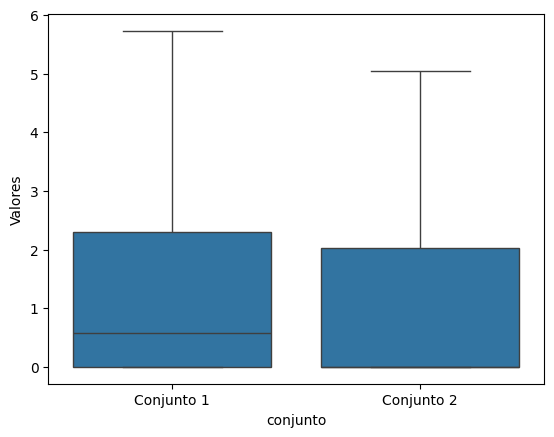

In [72]:
sns.boxplot(x='conjunto', y='valores', data=pd.DataFrame({'conjunto': ['Conjunto 1'] * len(coords_error_c1) + ['Conjunto 2'] * len(coords_error_c2), 'valores': np.concatenate([coords_error_c1, coords_error_c2])}), showfliers=False)

# Adicionar rótulo ao eixo y
plt.ylabel('Valores')


# Exibir o gráfico
plt.show()

### 3.2 SVM

#### 3.2.1 Tuning Parameter

Vamos testar o SVM variando os parâmetros de C, e o 3 kerneis (Linar, Poly, RBF)

In [5]:
## Chamar os modelos com variável nos parâmetros
C = [50,100,150,200]
kernel = ["linear", "poly", "rbf"]

Vamos variar C para o kernel RBF, default da função 

In [6]:
scores_clf_flr = []
scores_clf_build = []
scores_reg_lat = []
scores_reg_log = []

# Loop para variar os parâmetros
for C_in in C:
    # Cria o SVM
    svm_clf = SVC(C=C_in, kernel="rbf", max_iter=3000)
    svm_clf = MultiOutputClassifier(svm_clf)
    svm_regr = SVR(C=C_in, kernel="rbf", max_iter=3000)
    svm_regr = MultiOutputRegressor(svm_regr)

    # Treinamento e validação
    ## Fit e predict classifier
    fit = svm_clf.fit(X_train, y_train[CATEGORICAL_COLUMNS])
    prediction_clf = fit.predict(X_val)
    fit = svm_regr.fit(X_train, y_train[QUANTITATIVE_COLUMNS])
    prediction_reg = fit.predict(X_val)

    # Calcula acurácia e erro
    acc_score1 = accuracy_score(y_val["FLOOR"].values, prediction_clf[:,0])
    acc_score2 = accuracy_score(y_val["BUILDINGID"], prediction_clf[:,1])

    mse_latitude = mean_squared_error(y_val["LATITUDE"].values, prediction_reg[:, 1])
    mse_longitude = mean_squared_error(y_val["LONGITUDE"].values, prediction_reg[:, 0])

    # Armazena as médias
    scores_clf_flr.append(acc_score1)
    scores_clf_build.append(acc_score2)
    scores_reg_lat.append(mse_latitude)
    scores_reg_log.append(mse_longitude)

C:\Users\yannm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\yannm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\yannm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\yannm\AppData\Local\Packages\PythonSoftwareFou

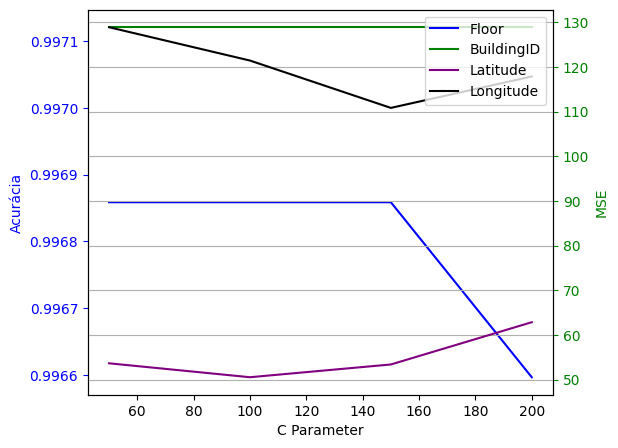

In [7]:
# Criação do gráfico
fig, ax1 = plt.subplots(figsize=(6, 5))

# Plota y1 e y2 no primeiro eixo y
ax1.plot(C, scores_clf_flr, label='Floor', color='blue')
ax1.plot(C, scores_clf_build, label='BuildingID', color='Green')
ax1.set_xlabel('C Parameter')
ax1.set_ylabel('Acurácia', color='blue')
ax1.tick_params('y', colors='blue')

# Cria um segundo eixo y compartilhando o mesmo eixo x
ax2 = ax1.twinx()
ax2.plot(C, scores_reg_lat, label='Latitude', color='purple')
ax2.plot(C, scores_reg_log, label='Longitude', color='black')
ax2.set_ylabel('MSE', color='green')
ax2.tick_params('y', colors='green')

# Adiciona legenda
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

#plt.title('Gráfico de Linhas com Duas Escalas')
plt.grid()
plt.show()

Mantendo agora C = 100, vamos variar o tipo de Kernel

In [8]:
scores_clf_flr = []
scores_clf_build = []
scores_reg_lat = []
scores_reg_log = []

# Loop para variar os parâmetros
for knl in kernel:
    # Cria o SVM
    svm_clf = SVC(C=100, kernel=knl, max_iter=3000)
    svm_clf = MultiOutputClassifier(svm_clf)
    svm_regr = SVR(C=100, kernel=knl, max_iter=3000)
    svm_regr = MultiOutputRegressor(svm_regr)

    # Treinamento e validação
    ## Fit e predict classifier
    fit = svm_clf.fit(X_train, y_train[CATEGORICAL_COLUMNS])
    prediction_clf = fit.predict(X_val)
    fit = svm_regr.fit(X_train, y_train[QUANTITATIVE_COLUMNS])
    prediction_reg = fit.predict(X_val)

    # Calcula acurácia e erro
    acc_score1 = accuracy_score(y_val["FLOOR"].values, prediction_clf[:,0])
    acc_score2 = accuracy_score(y_val["BUILDINGID"], prediction_clf[:,1])

    mse_latitude = mean_squared_error(y_val["LATITUDE"].values, prediction_reg[:, 1])
    mse_longitude = mean_squared_error(y_val["LONGITUDE"].values, prediction_reg[:, 0])

    # Armazena as médias
    scores_clf_flr.append(acc_score1)
    scores_clf_build.append(acc_score2)
    scores_reg_lat.append(mse_latitude)
    scores_reg_log.append(mse_longitude)

C:\Users\yannm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\yannm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\yannm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\yannm\AppData\Local\Packages\PythonSoftwareFou

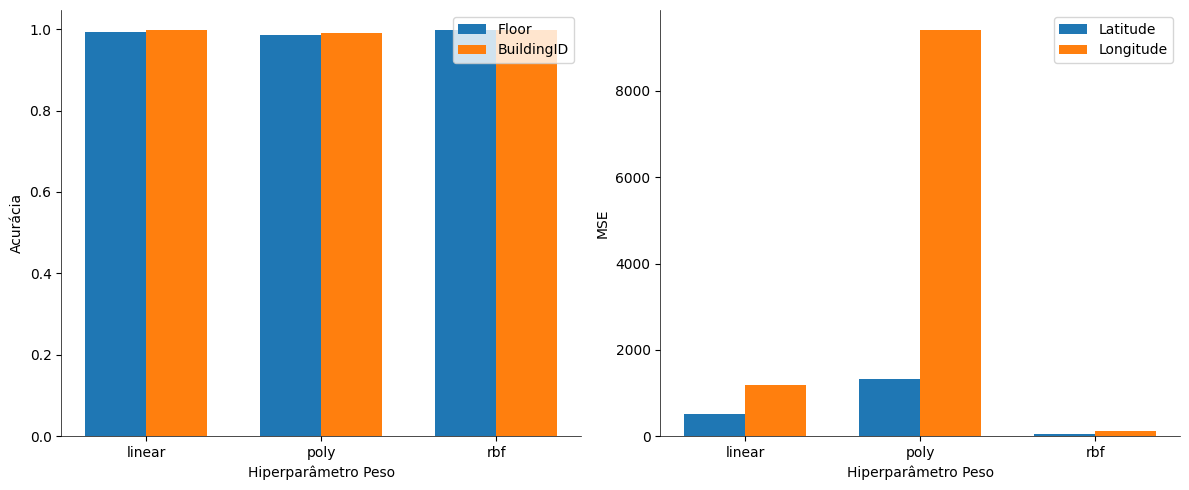

In [9]:
largura_barra = 0.35

# Criação dos gráficos de barras agrupadas
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Gráfico 1: y1 e y2
largura_barra = 0.35
posicoes1 = np.arange(len(kernel))
ax1.bar(posicoes1 - largura_barra/2, scores_clf_flr, largura_barra, label='Floor')
ax1.bar(posicoes1 + largura_barra/2, scores_clf_build, largura_barra, label='BuildingID')
ax1.set_xticks(posicoes1)
ax1.set_xticklabels(kernel)
ax1.set_xlabel('Hiperparâmetro Peso')
ax1.set_ylabel('Acurácia')
ax1.legend(loc='upper right')

# Remove as linhas de borda, mantendo apenas as linhas da escala
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_linewidth(0.5)
ax1.spines['left'].set_linewidth(0.5)

# Gráfico 2: y3 e y4 agrupados
posicoes2 = np.arange(len(kernel))
ax2.bar(posicoes2 - largura_barra/2, scores_reg_lat, largura_barra, label='Latitude')
ax2.bar(posicoes2 + largura_barra/2, scores_reg_log, largura_barra, label='Longitude')
ax2.set_xticks(posicoes2)
ax2.set_xticklabels(kernel)
ax2.set_xlabel('Hiperparâmetro Peso')
ax2.set_ylabel('MSE')
ax2.legend(loc='upper right')

# Remove as linhas de borda, mantendo apenas as linhas da escala
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_linewidth(0.5)
ax2.spines['left'].set_linewidth(0.5)

# Ajusta o layout para evitar sobreposição
plt.tight_layout()

# Exibe os gráficos
plt.show()

#### 3.2.2 Validação Cruzada

##### ESTATISTICA CLASSIFICAÇÃO:

Vamos validar o modelo com a validação cruzada

In [129]:
svm_clf = SVC(C=150, kernel='rbf', max_iter=3000)
#svm_clf = MultiOutputClassifier(svm_clf)
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
skf_flr_c1 = cross_validate(svm_clf, X, Y['FLOOR'], cv=stratified_cv, scoring=('balanced_accuracy'))
skf_bld_c1 = cross_validate(svm_clf, X, Y['BUILDINGID'], cv=stratified_cv, scoring=('balanced_accuracy'))
skf_flr_c2 = cross_validate(svm_clf, X_reduced_clf, Y_new['FLOOR'], cv=stratified_cv, scoring=('balanced_accuracy'))
skf_bld_c2 = cross_validate(svm_clf, X_reduced_clf, Y_new['BUILDINGID'], cv=stratified_cv, scoring=('balanced_accuracy'))

C:\Users\yannm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\yannm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\yannm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\yannm\AppData\Local\Packages\PythonSoftwareFou

In [130]:
estatistica_clf = {
    'Estatística': ['Maxima Acurácia','Minima Acurácia','Acurácia Média','Std Acurácia'],
    'Conjunto 1 Floor': [max(skf_flr_c1['test_score']), min(skf_flr_c1['test_score']), mean(skf_flr_c1['test_score']),stdev(skf_flr_c1['test_score'])],
    'Conjunto 2 Floor': [max(skf_flr_c2['test_score']), min(skf_flr_c2['test_score']), mean(skf_flr_c2['test_score']),stdev(skf_flr_c2['test_score'])],
    'Conjunto 1 Building': [max(skf_bld_c1['test_score']), min(skf_bld_c1['test_score']), mean(skf_bld_c1['test_score']),stdev(skf_bld_c1['test_score'])],
    'Conjunto 2 Building': [max(skf_bld_c2['test_score']), min(skf_bld_c2['test_score']), mean(skf_bld_c2['test_score']),stdev(skf_bld_c2['test_score'])]
}

df_stat_clf = pd.DataFrame(estatistica_clf)
display(df_stat_clf)

,Estatística,Conjunto 1 Floor,Conjunto 2 Floor,Conjunto 1 Building,Conjunto 2 Building
0,Maxima Acurácia,0.997550,0.942676,0.999079,0.970325
1,Minima Acurácia,0.996837,0.933769,0.997975,0.965008
2,Acurácia Média,0.997231,0.937522,0.998537,0.967066
3,Std Acurácia,0.000305,0.003742,0.000406,0.002177


In [131]:
## Results from Analysis:
## KNN
svm_clf = SVC(C=150, kernel='rbf', max_iter=3000)
svm_clf = MultiOutputClassifier(svm_clf)

# Divide cada dataset
X_train, X_val, y_train, y_val = train_test_split(X, Y.values, test_size=0.2, random_state=0)
y_train = DataFrame(y_train, columns=Y.columns)
y_val = DataFrame(y_val, columns=Y.columns)

X_train_new, X_val_new, y_train_new, y_val_new = train_test_split(X_reduced_clf, Y_new.values, test_size=0.2, random_state=0)
y_train_new = DataFrame(y_train_new, columns=Y_new.columns)
y_val_new = DataFrame(y_val_new, columns=Y_new.columns)

y_train_new['FLOOR'] = pd.to_numeric(y_train_new['FLOOR'], errors='coerce')
y_val_new['FLOOR'] = pd.to_numeric(y_val_new['FLOOR'], errors='coerce')
y_train_new['BUILDINGID'] = pd.to_numeric(y_train_new['BUILDINGID'], errors='coerce')
y_val_new['BUILDINGID'] = pd.to_numeric(y_val_new['BUILDINGID'], errors='coerce')

#Fit e predict do modelo
fit = svm_clf.fit(X_train, y_train[CATEGORICAL_COLUMNS])
prediction_clf_c1 = fit.predict(X_val)
clf_prediction_c1 = DataFrame(prediction_clf_c1, columns=[CATEGORICAL_COLUMNS])

fit = svm_clf.fit(X_train_new, y_train_new[CATEGORICAL_COLUMNS])
prediction_clf_c2 = fit.predict(X_val_new)
clf_prediction_c2 = DataFrame(prediction_clf_c2, columns=[CATEGORICAL_COLUMNS])

#Matriz de confusão
cm_flr_c1 = confusion_matrix(y_val['FLOOR'], clf_prediction_c1['FLOOR'])
cm_flr_c2 = confusion_matrix(y_val_new['FLOOR'], clf_prediction_c2['FLOOR'])
cm_bld_c1 = confusion_matrix(y_val['BUILDINGID'], clf_prediction_c1['BUILDINGID'])
cm_bld_c2 = confusion_matrix(y_val_new['BUILDINGID'], clf_prediction_c2['BUILDINGID'])

C:\Users\yannm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\yannm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


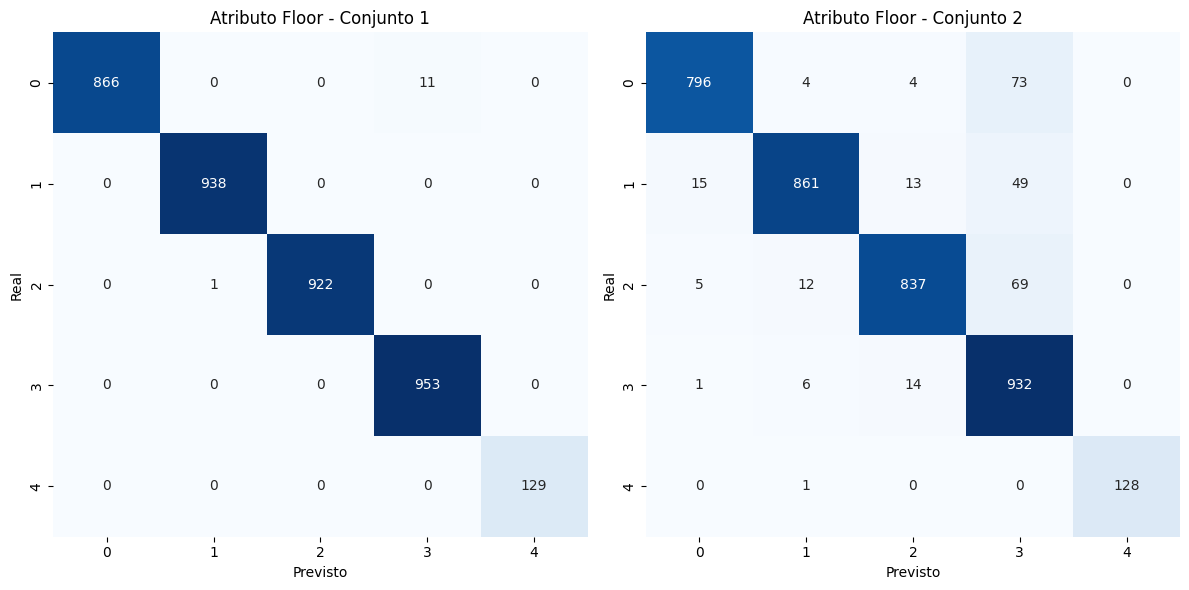

In [132]:
# Configuração do subplot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plotagem do heatmap para cm1
sns.heatmap(cm_flr_c1, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[0])
axes[0].set_title('Atributo Floor - Conjunto 1')
axes[0].set_xlabel('Previsto')
axes[0].set_ylabel('Real')

# Plotagem do heatmap para cm2
sns.heatmap(cm_flr_c2, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[1])
axes[1].set_title('Atributo Floor - Conjunto 2')
axes[1].set_xlabel('Previsto')
axes[1].set_ylabel('Real')

# Ajusta o layout
plt.tight_layout()
plt.show()

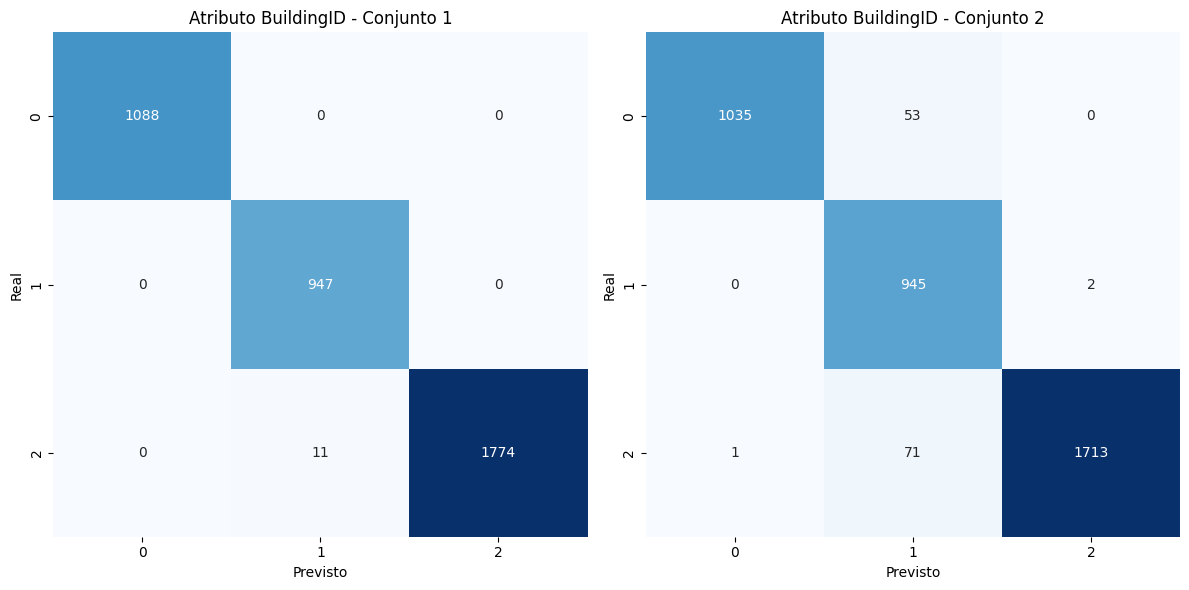

In [133]:
# Configuração do subplot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plotagem do heatmap para cm1
sns.heatmap(cm_bld_c1, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[0])
axes[0].set_title('Atributo BuildingID - Conjunto 1')
axes[0].set_xlabel('Previsto')
axes[0].set_ylabel('Real')

# Plotagem do heatmap para cm2
sns.heatmap(cm_bld_c2, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[1])
axes[1].set_title('Atributo BuildingID - Conjunto 2')
axes[1].set_xlabel('Previsto')
axes[1].set_ylabel('Real')

# Ajusta o layout
plt.tight_layout()
plt.show()

##### ESTATÍSTICAS REGRESSÃO:

In [134]:
svm_regr = SVR(C=150, kernel="rbf", max_iter=3000)
#svm_regr = MultiOutputRegressor(svm_regr)
skf_lat_c1 = cross_validate(svm_regr, X, Y['LATITUDE'], cv=5, scoring=('r2', 'neg_mean_squared_error'))
skf_log_c1 = cross_validate(svm_regr, X, Y['LONGITUDE'], cv=5, scoring=('r2', 'neg_mean_squared_error'))
skf_lat_c2 = cross_validate(svm_regr, X_reduced_reg, Y_new['LATITUDE'], cv=5, scoring=('r2', 'neg_mean_squared_error'))
skf_log_c2 = cross_validate(svm_regr, X_reduced_reg, Y_new['LONGITUDE'], cv=5, scoring=('r2', 'neg_mean_squared_error'))

C:\Users\yannm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\yannm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\yannm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\yannm\AppData\Local\Packages\PythonSoftwareFou

In [135]:
estatistica_reg = {
    'Estatística': ['Maximo MSE','Minimo MSE','MSE Médio','Std MSE','Maximo r2','Minimo r2','r2 Médio','Std r2'],
    'Conjunto 1 Latitude (m)': [max(skf_lat_c1['test_neg_mean_squared_error']), min(skf_lat_c1['test_neg_mean_squared_error']), mean(skf_lat_c1['test_neg_mean_squared_error']),stdev(skf_lat_c1['test_neg_mean_squared_error']),max(skf_lat_c1['test_r2']), min(skf_lat_c1['test_r2']), mean(skf_lat_c1['test_r2']),stdev(skf_lat_c1['test_r2'])],
    'Conjunto 2 Latitude (m)': [max(skf_lat_c2['test_neg_mean_squared_error']), min(skf_lat_c2['test_neg_mean_squared_error']), mean(skf_lat_c2['test_neg_mean_squared_error']),stdev(skf_lat_c2['test_neg_mean_squared_error']),max(skf_lat_c2['test_r2']), min(skf_lat_c2['test_r2']), mean(skf_lat_c2['test_r2']),stdev(skf_lat_c2['test_r2'])],
    'Conjunto 1 Longitude (m)': [max(skf_log_c1['test_neg_mean_squared_error']), min(skf_log_c1['test_neg_mean_squared_error']), mean(skf_log_c1['test_neg_mean_squared_error']),stdev(skf_log_c1['test_neg_mean_squared_error']),max(skf_log_c1['test_r2']), min(skf_log_c1['test_r2']), mean(skf_log_c1['test_r2']),stdev(skf_log_c1['test_r2'])],
    'Conjunto 2 Longitude (m)': [max(skf_log_c2['test_neg_mean_squared_error']), min(skf_log_c2['test_neg_mean_squared_error']), mean(skf_log_c2['test_neg_mean_squared_error']),stdev(skf_log_c2['test_neg_mean_squared_error']),max(skf_log_c2['test_r2']), min(skf_log_c2['test_r2']), mean(skf_log_c2['test_r2']),stdev(skf_log_c2['test_r2'])]
}

df_stat_reg = pd.DataFrame(estatistica_reg)
display(df_stat_reg)

,Estatística,Conjunto 1 Latitude (m),Conjunto 2 Latitude (m),Conjunto 1 Longitude (m),Conjunto 2 Longitude (m)
0,Maximo MSE,-62.298922,-393.287280,-193.952419,-951.986663
1,Minimo MSE,-2198.743690,-1538.751948,-1201.923085,-2672.679010
2,MSE Médio,-548.618461,-743.087403,-470.420868,-2051.175488
3,Std MSE,925.452695,461.116320,416.528870,664.437284
4,Maximo r2,0.984924,0.892960,0.988772,0.906500
5,Minimo r2,0.134088,0.394007,0.752766,0.585372
6,r2 Médio,0.789945,0.748702,0.930357,0.780873
7,Std r2,0.368131,0.203394,0.100065,0.133982


O erro de localização será, para cada conjunto de dados:

In [136]:
## Results from Analysis:
## KNN
svm_regr = SVR(C=150, kernel="rbf", max_iter=3000)
svm_regr = MultiOutputRegressor(svm_regr)

# Divide cada dataset
X_train, X_val, y_train, y_val = train_test_split(X, Y.values, test_size=0.2, random_state=0)

y_train = DataFrame(y_train, columns=Y.columns)
y_val = DataFrame(y_val, columns=Y.columns)

X_train_new, X_val_new, y_train_new, y_val_new = train_test_split(X_reduced_reg, Y_new.values, test_size=0.2, random_state=0)

y_train_new = DataFrame(y_train_new, columns=Y_new.columns)
y_val_new = DataFrame(y_val_new, columns=Y_new.columns)

#Fit e predict do modelo
fit = svm_regr.fit(X_train, y_train[QUANTITATIVE_COLUMNS])
prediction_reg_c1 = fit.predict(X_val)
regr_prediction_c1 = DataFrame(prediction_reg_c1, columns=QUANTITATIVE_COLUMNS)

fit = svm_regr.fit(X_train_new, y_train_new[QUANTITATIVE_COLUMNS])
prediction_reg_c2 = fit.predict(X_val_new)
regr_prediction_c2 = DataFrame(prediction_reg_c2, columns=QUANTITATIVE_COLUMNS)

# Convertendo dados para cálculo
regr_prediction_c2['LONGITUDE'] = pd.to_numeric(regr_prediction_c2['LONGITUDE'], errors='coerce')
regr_prediction_c2['LATITUDE'] = pd.to_numeric(regr_prediction_c2['LATITUDE'], errors='coerce')
y_val_new['LATITUDE'] = pd.to_numeric(y_val_new['LATITUDE'], errors='coerce')
y_val_new['LONGITUDE'] = pd.to_numeric(y_val_new['LONGITUDE'], errors='coerce')

# Calcula o erro
coords_error_c1 = localizaion_error(regr_prediction_c1, y_val)
coords_error_c2 = localizaion_error(regr_prediction_c2, y_val_new)



C:\Users\yannm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\yannm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\yannm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\yannm\AppData\Local\Packages\PythonSoftwareFou

In [137]:
sem_outliers_c2 = coords_error_c2[~((coords_error_c2 - np.mean(coords_error_c2)) > 3 * np.std(coords_error_c2))]
sem_outliers_c1 = coords_error_c1[~((coords_error_c1 - np.mean(coords_error_c1)) > 3 * np.std(coords_error_c1))]
quartis_c1 = np.percentile(coords_error_c1, [25, 50, 75])
quartis_c2 = np.percentile(coords_error_c2, [25, 50, 75])

estatistica_bxp = {
    'Estatística': ['Média','Desvio Padrão','Mediana','Q1','Q3','Intervalo Interquartil','Quantidade de Amostras'],
    'Conjunto 1 (Com Outliers)': [np.mean(coords_error_c1), np.std(coords_error_c1), np.median(coords_error_c1),quartis_c1[0],quartis_c1[2],quartis_c1[2]-quartis_c1[0],len(coords_error_c1)],
    'Conjunto 2 (Com Outliers)': [np.mean(coords_error_c2), np.std(coords_error_c2), np.median(coords_error_c2),quartis_c2[0],quartis_c2[2],quartis_c2[2]-quartis_c2[0],len(coords_error_c2)],
    'Conjunto 1 (Sem Outliers)': [np.mean(sem_outliers_c1), np.std(sem_outliers_c1), np.median(sem_outliers_c1),quartis_c1[0],quartis_c1[2],quartis_c1[2]-quartis_c1[0],len(sem_outliers_c1)],
    'Conjunto 2 (Sem Outliers)': [np.mean(sem_outliers_c2), np.std(sem_outliers_c2), np.median(sem_outliers_c2),quartis_c2[0],quartis_c2[2],quartis_c2[2]-quartis_c2[0],len(sem_outliers_c2)]
}

df_stat_bxp = pd.DataFrame(estatistica_bxp)
display(df_stat_bxp)

,Estatística,Conjunto 1 (Com Outliers),Conjunto 2 (Com Outliers),Conjunto 1 (Sem Outliers),Conjunto 2 (Sem Outliers)
0,Média,8.362754,22.290303,7.437319,17.846209
1,Desvio Padrão,9.709379,30.093066,4.976057,16.016237
2,Mediana,6.502213,13.580434,6.445705,13.284560
3,Q1,4.188472,8.629411,4.188472,8.629411
4,Q3,9.597187,22.290194,9.597187,22.290194
5,Intervalo Interquartil,5.408715,13.660784,5.408715,13.660784
6,Quantidade de Amostras,3820.000000,3820.000000,3763.000000,3701.000000


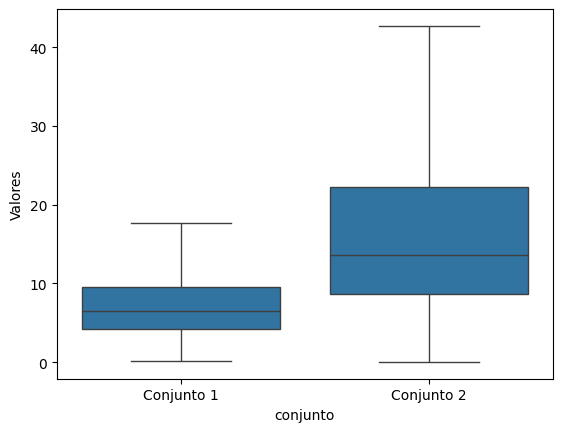

In [138]:
sns.boxplot(x='conjunto', y='valores', data=pd.DataFrame({'conjunto': ['Conjunto 1'] * len(coords_error_c1) + ['Conjunto 2'] * len(coords_error_c2), 'valores': np.concatenate([coords_error_c1, coords_error_c2])}), showfliers=False)

# Adicionar rótulo ao eixo y
plt.ylabel('Valores')


# Exibir o gráfico
plt.show()

### 3.3 Random Forest

#### 3.3.1 Tuning Parameter

Primeiro vamos avaliar o ponto ótimo dado pela função Rand Search

In [13]:
best_rf_clf = []
best_rf_reg = []

param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(10,300)}

# Create a random forest classifier
rf_clf = RandomForestClassifier()
rf_reg = RandomForestRegressor()

# Use random search to find the best hyperparameters
rand_search_clf = RandomizedSearchCV(rf_clf, 
                                 param_distributions = param_dist, 
                                 n_iter=10, 
                                 cv=5)

# Use random search to find the best hyperparameters
rand_search_reg = RandomizedSearchCV(rf_reg, 
                                 param_distributions = param_dist, 
                                 n_iter=10, 
                                 cv=5)

for QL in CATEGORICAL_COLUMNS:
    # Fit the random search object to the data
    rand_search_clf.fit(X_train, y_train[QL])

    # Create a variable for the best model
    best_rf = rand_search_clf.best_estimator_

    # Create a variable for the best model
    best_rf_clf.append(best_rf)

for QT in QUANTITATIVE_COLUMNS:
    # Fit the random search object to the data
    rand_search_reg.fit(X_train, y_train[QT])

    # Create a variable for the best model
    best_rf = rand_search_reg.best_estimator_

    # Create a variable for the best model
    best_rf_reg.append(rand_search_reg.best_rf)

# Print the best hyperparameters
print('Best hyperparameters Classifier:',  rand_search_clf)
print('Best hyperparameters Regressor:',  rand_search_reg)

ValueError: 
All the 50 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yannm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yannm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\yannm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_forest.py", line 390, in fit
    y, expanded_class_weight = self._validate_y_class_weight(y)
                               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\yannm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_forest.py", line 749, in _validate_y_class_weight
    check_classification_targets(y)
  File "C:\Users\yannm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\multiclass.py", line 215, in check_classification_targets
    raise ValueError(
ValueError: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.


In [15]:
print('Best hyperparameters Classifier:',  rand_search_clf.best_estimator_)

Best hyperparameters Classifier: RandomForestClassifier(max_depth=149, n_estimators=394)


Podemos agora avaliar como se comporta o Random Forest quando variamos os hiper-parâmetros num intervalo, individualmente.

In [5]:
## Chamar os modelos com variável nos parâmetros
max_dept = [50,100,150,200]
m_nodes = [250,300,350,400]

In [7]:
scores_clf_flr = []
scores_clf_build = []
scores_reg_lat = []
scores_reg_log = []

# Loop para variar os parâmetros
for md in max_dept:
# Cria o SVM
    rf_clf = RandomForestClassifier(n_estimators=100,max_depth=md)
    rf_regr = RandomForestRegressor(n_estimators=100,max_depth=md)

    # Treinamento e validação
    ## Fit e predict classifier
    fit = rf_clf.fit(X_train, y_train[CATEGORICAL_COLUMNS])
    prediction_clf = fit.predict(X_val)
    fit = rf_regr.fit(X_train, y_train[QUANTITATIVE_COLUMNS])
    prediction_reg = fit.predict(X_val)

    # Calcula acurácia e erro
    acc_score1 = accuracy_score(y_val["FLOOR"].values, prediction_clf[:,0])
    acc_score2 = accuracy_score(y_val["BUILDINGID"], prediction_clf[:,1])

    mse_latitude = mean_squared_error(y_val["LATITUDE"].values, prediction_reg[:, 1])
    mse_longitude = mean_squared_error(y_val["LONGITUDE"].values, prediction_reg[:, 0])

    # Armazena as médias
    scores_clf_flr.append(acc_score1)
    scores_clf_build.append(acc_score2)
    scores_reg_lat.append(mse_latitude)
    scores_reg_log.append(mse_longitude)

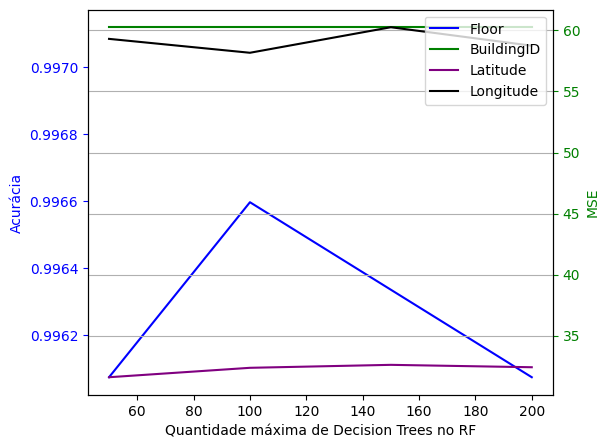

In [10]:
# Criação do gráfico
fig, ax1 = plt.subplots(figsize=(6, 5))

# Plota y1 e y2 no primeiro eixo y
ax1.plot(max_dept, scores_clf_flr, label='Floor', color='blue')
ax1.plot(max_dept, scores_clf_build, label='BuildingID', color='Green')
ax1.set_xlabel('Quantidade máxima de Decision Trees no RF')
ax1.set_ylabel('Acurácia', color='blue')
ax1.tick_params('y', colors='blue')

# Cria um segundo eixo y compartilhando o mesmo eixo x
ax2 = ax1.twinx()
ax2.plot(max_dept, scores_reg_lat, label='Latitude', color='purple')
ax2.plot(max_dept, scores_reg_log, label='Longitude', color='black')
ax2.set_ylabel('MSE', color='green')
ax2.tick_params('y', colors='green')

# Adiciona legenda
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

#plt.title('Gráfico de Linhas com Duas Escalas')
plt.grid()
plt.show()

Variando agora o m

In [11]:
scores_clf_flr = []
scores_clf_build = []
scores_reg_lat = []
scores_reg_log = []

# Loop para variar os parâmetros
for mn in m_nodes:
# Cria o SVM
    rf_clf = RandomForestClassifier(n_estimators=mn,max_depth=100)
    rf_regr = RandomForestRegressor(n_estimators=mn,max_depth=100)

    # Treinamento e validação
    ## Fit e predict classifier
    fit = rf_clf.fit(X_train, y_train[CATEGORICAL_COLUMNS])
    prediction_clf = fit.predict(X_val)
    fit = rf_regr.fit(X_train, y_train[QUANTITATIVE_COLUMNS])
    prediction_reg = fit.predict(X_val)

    # Calcula acurácia e erro
    acc_score1 = accuracy_score(y_val["FLOOR"].values, prediction_clf[:,0])
    acc_score2 = accuracy_score(y_val["BUILDINGID"], prediction_clf[:,1])

    mse_latitude = mean_squared_error(y_val["LATITUDE"].values, prediction_reg[:, 1])
    mse_longitude = mean_squared_error(y_val["LONGITUDE"].values, prediction_reg[:, 0])

    # Armazena as médias
    scores_clf_flr.append(acc_score1)
    scores_clf_build.append(acc_score2)
    scores_reg_lat.append(mse_latitude)
    scores_reg_log.append(mse_longitude)

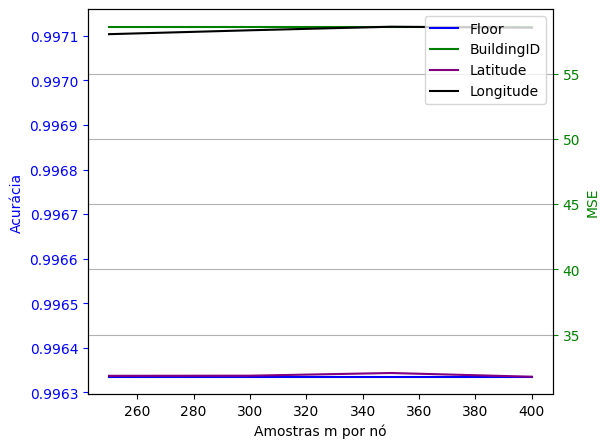

In [13]:
# Criação do gráfico
fig, ax1 = plt.subplots(figsize=(6, 5))

# Plota y1 e y2 no primeiro eixo y
ax1.plot(m_nodes, scores_clf_flr, label='Floor', color='blue')
ax1.plot(m_nodes, scores_clf_build, label='BuildingID', color='Green')
ax1.set_xlabel('Amostras m por nó')
ax1.set_ylabel('Acurácia', color='blue')
ax1.tick_params('y', colors='blue')

# Cria um segundo eixo y compartilhando o mesmo eixo x
ax2 = ax1.twinx()
ax2.plot(m_nodes, scores_reg_lat, label='Latitude', color='purple')
ax2.plot(m_nodes, scores_reg_log, label='Longitude', color='black')
ax2.set_ylabel('MSE', color='green')
ax2.tick_params('y', colors='green')

# Adiciona legenda
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

#plt.title('Gráfico de Linhas com Duas Escalas')
plt.grid()
plt.show()

#### 3.3.2 Validação Cruzada

##### ESTATISTICA CLASSIFICAÇÃO:

In [139]:
rf_clf = RandomForestClassifier(n_estimators=350,max_depth=100)
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
skf_flr_c1 = cross_validate(rf_clf, X, Y['FLOOR'], cv=stratified_cv, scoring=('balanced_accuracy'))
skf_bld_c1 = cross_validate(rf_clf, X, Y['BUILDINGID'], cv=stratified_cv, scoring=('balanced_accuracy'))
skf_flr_c2 = cross_validate(rf_clf, X_reduced_clf, Y_new['FLOOR'], cv=stratified_cv, scoring=('balanced_accuracy'))
skf_bld_c2 = cross_validate(rf_clf, X_reduced_clf, Y_new['BUILDINGID'], cv=stratified_cv, scoring=('balanced_accuracy'))


In [140]:
estatistica_clf = {
    'Estatística': ['Maxima Acurácia','Minima Acurácia','Acurácia Média','Std Acurácia'],
    'Conjunto 1 Floor': [max(skf_flr_c1['test_score']), min(skf_flr_c1['test_score']), mean(skf_flr_c1['test_score']),stdev(skf_flr_c1['test_score'])],
    'Conjunto 2 Floor': [max(skf_flr_c2['test_score']), min(skf_flr_c2['test_score']), mean(skf_flr_c2['test_score']),stdev(skf_flr_c2['test_score'])],
    'Conjunto 1 Building': [max(skf_bld_c1['test_score']), min(skf_bld_c1['test_score']), mean(skf_bld_c1['test_score']),stdev(skf_bld_c1['test_score'])],
    'Conjunto 2 Building': [max(skf_bld_c2['test_score']), min(skf_bld_c2['test_score']), mean(skf_bld_c2['test_score']),stdev(skf_bld_c2['test_score'])]
}

df_stat_clf = pd.DataFrame(estatistica_clf)
display(df_stat_clf)

,Estatística,Conjunto 1 Floor,Conjunto 2 Floor,Conjunto 1 Building,Conjunto 2 Building
0,Maxima Acurácia,0.997521,0.950777,0.998393,0.971328
1,Minima Acurácia,0.994939,0.942826,0.995481,0.966045
2,Acurácia Média,0.996603,0.946963,0.997258,0.968108
3,Std Acurácia,0.001027,0.003359,0.001114,0.002573


In [141]:
## Results from Analysis:
## KNN
rf_clf = RandomForestClassifier(n_estimators=350,max_depth=100)
rf_clf = MultiOutputClassifier(rf_clf)

# Divide cada dataset
X_train, X_val, y_train, y_val = train_test_split(X, Y.values, test_size=0.2, random_state=0)
y_train = DataFrame(y_train, columns=Y.columns)
y_val = DataFrame(y_val, columns=Y.columns)

X_train_new, X_val_new, y_train_new, y_val_new = train_test_split(X_reduced_clf, Y_new.values, test_size=0.2, random_state=0)
y_train_new = DataFrame(y_train_new, columns=Y_new.columns)
y_val_new = DataFrame(y_val_new, columns=Y_new.columns)

y_train_new['FLOOR'] = pd.to_numeric(y_train_new['FLOOR'], errors='coerce')
y_val_new['FLOOR'] = pd.to_numeric(y_val_new['FLOOR'], errors='coerce')
y_train_new['BUILDINGID'] = pd.to_numeric(y_train_new['BUILDINGID'], errors='coerce')
y_val_new['BUILDINGID'] = pd.to_numeric(y_val_new['BUILDINGID'], errors='coerce')

#Fit e predict do modelo
fit = rf_clf.fit(X_train, y_train[CATEGORICAL_COLUMNS])
prediction_clf_c1 = fit.predict(X_val)
clf_prediction_c1 = DataFrame(prediction_clf_c1, columns=[CATEGORICAL_COLUMNS])

fit = rf_clf.fit(X_train_new, y_train_new[CATEGORICAL_COLUMNS])
prediction_clf_c2 = fit.predict(X_val_new)
clf_prediction_c2 = DataFrame(prediction_clf_c2, columns=[CATEGORICAL_COLUMNS])

#Matriz de confusão
cm_flr_c1 = confusion_matrix(y_val['FLOOR'], clf_prediction_c1['FLOOR'])
cm_flr_c2 = confusion_matrix(y_val_new['FLOOR'], clf_prediction_c2['FLOOR'])
cm_bld_c1 = confusion_matrix(y_val['BUILDINGID'], clf_prediction_c1['BUILDINGID'])
cm_bld_c2 = confusion_matrix(y_val_new['BUILDINGID'], clf_prediction_c2['BUILDINGID'])

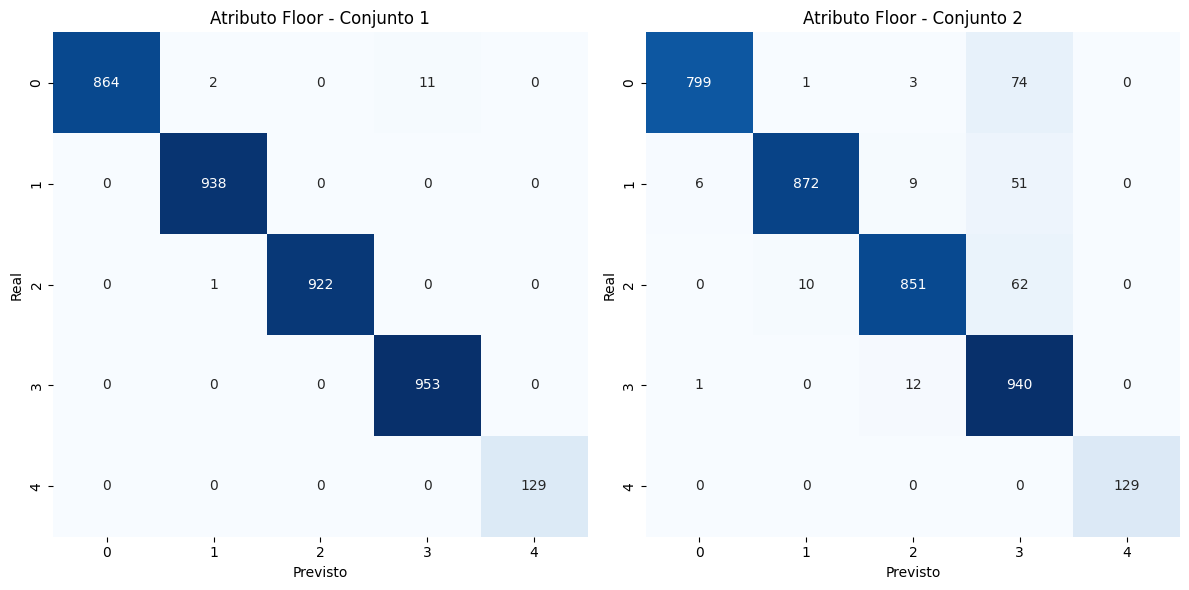

In [142]:
# Configuração do subplot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plotagem do heatmap para cm1
sns.heatmap(cm_flr_c1, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[0])
axes[0].set_title('Atributo Floor - Conjunto 1')
axes[0].set_xlabel('Previsto')
axes[0].set_ylabel('Real')

# Plotagem do heatmap para cm2
sns.heatmap(cm_flr_c2, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[1])
axes[1].set_title('Atributo Floor - Conjunto 2')
axes[1].set_xlabel('Previsto')
axes[1].set_ylabel('Real')

# Ajusta o layout
plt.tight_layout()
plt.show()

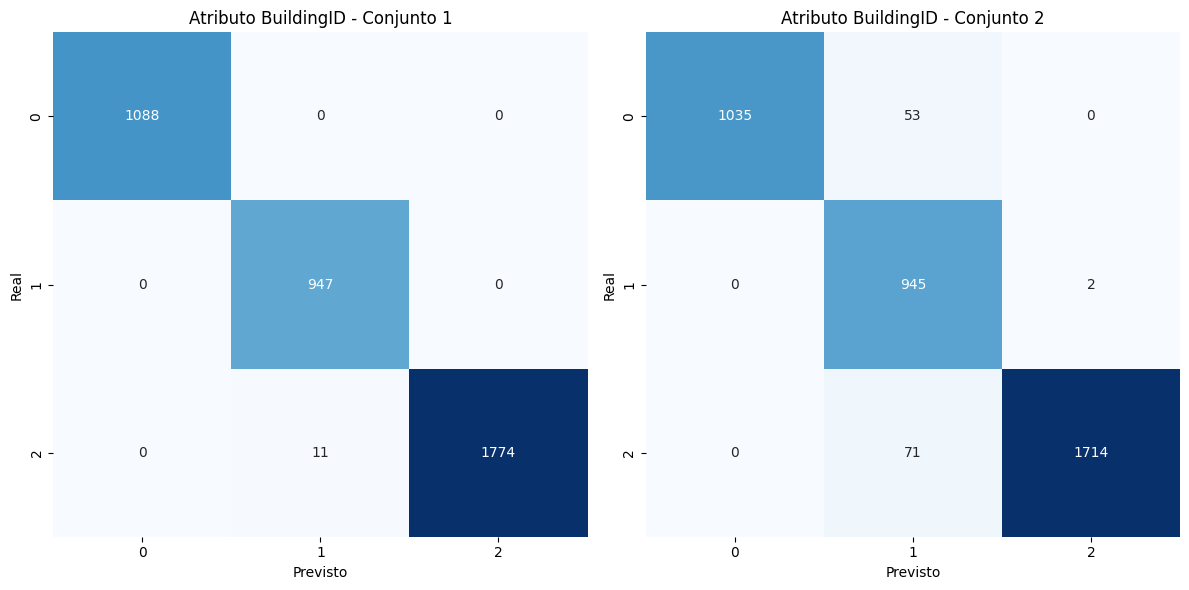

In [143]:
# Configuração do subplot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plotagem do heatmap para cm1
sns.heatmap(cm_bld_c1, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[0])
axes[0].set_title('Atributo BuildingID - Conjunto 1')
axes[0].set_xlabel('Previsto')
axes[0].set_ylabel('Real')

# Plotagem do heatmap para cm2
sns.heatmap(cm_bld_c2, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[1])
axes[1].set_title('Atributo BuildingID - Conjunto 2')
axes[1].set_xlabel('Previsto')
axes[1].set_ylabel('Real')

# Ajusta o layout
plt.tight_layout()
plt.show()

##### ESTATÍSTICAS REGRESSÃO:

In [146]:
rf_regr = RandomForestRegressor(n_estimators=350,max_depth=100)
#rf_regr = MultiOutputRegressor(rf_regr)
skf_lat_c1 = cross_validate(rf_regr, X, Y['LATITUDE'], cv=3, scoring=('r2', 'neg_mean_squared_error'))
skf_log_c1 = cross_validate(rf_regr, X, Y['LONGITUDE'], cv=3, scoring=('r2', 'neg_mean_squared_error'))
skf_lat_c2 = cross_validate(rf_regr, X_reduced_reg, Y_new['LATITUDE'], cv=3, scoring=('r2', 'neg_mean_squared_error'))
skf_log_c2 = cross_validate(rf_regr, X_reduced_reg, Y_new['LONGITUDE'], cv=3, scoring=('r2', 'neg_mean_squared_error'))

In [147]:
estatistica_reg = {
    'Estatística': ['Maximo MSE','Minimo MSE','MSE Médio','Std MSE','Maximo r2','Minimo r2','r2 Médio','Std r2'],
    'Conjunto 1 Latitude (m)': [max(skf_lat_c1['test_neg_mean_squared_error']), min(skf_lat_c1['test_neg_mean_squared_error']), mean(skf_lat_c1['test_neg_mean_squared_error']),stdev(skf_lat_c1['test_neg_mean_squared_error']),max(skf_lat_c1['test_r2']), min(skf_lat_c1['test_r2']), mean(skf_lat_c1['test_r2']),stdev(skf_lat_c1['test_r2'])],
    'Conjunto 2 Latitude (m)': [max(skf_lat_c2['test_neg_mean_squared_error']), min(skf_lat_c2['test_neg_mean_squared_error']), mean(skf_lat_c2['test_neg_mean_squared_error']),stdev(skf_lat_c2['test_neg_mean_squared_error']),max(skf_lat_c2['test_r2']), min(skf_lat_c2['test_r2']), mean(skf_lat_c2['test_r2']),stdev(skf_lat_c2['test_r2'])],
    'Conjunto 1 Longitude (m)': [max(skf_log_c1['test_neg_mean_squared_error']), min(skf_log_c1['test_neg_mean_squared_error']), mean(skf_log_c1['test_neg_mean_squared_error']),stdev(skf_log_c1['test_neg_mean_squared_error']),max(skf_log_c1['test_r2']), min(skf_log_c1['test_r2']), mean(skf_log_c1['test_r2']),stdev(skf_log_c1['test_r2'])],
    'Conjunto 2 Longitude (m)': [max(skf_log_c2['test_neg_mean_squared_error']), min(skf_log_c2['test_neg_mean_squared_error']), mean(skf_log_c2['test_neg_mean_squared_error']),stdev(skf_log_c2['test_neg_mean_squared_error']),max(skf_log_c2['test_r2']), min(skf_log_c2['test_r2']), mean(skf_log_c2['test_r2']),stdev(skf_log_c2['test_r2'])]
}

df_stat_reg = pd.DataFrame(estatistica_reg)
display(df_stat_reg)

,Estatística,Conjunto 1 Latitude (m),Conjunto 2 Latitude (m),Conjunto 1 Longitude (m),Conjunto 2 Longitude (m)
0,Maximo MSE,-98.601549,-397.663794,-207.752034,-1119.401777
1,Minimo MSE,-511.235660,-1287.677043,-594.724425,-2929.708187
2,MSE Médio,-273.671007,-809.726414,-462.472292,-1820.896761
3,Std MSE,213.297830,448.649995,220.648452,971.458871
4,Maximo r2,0.977008,0.907274,0.988042,0.918636
5,Minimo r2,0.783458,0.454585,0.869844,0.750920
6,r2 Médio,0.905288,0.734916,0.942026,0.837620
7,Std r2,0.106059,0.244899,0.063294,0.084002


O erro de localização será, para cada conjunto de dados:

In [148]:
## Results from Analysis:
## KNN
rf_regr = RandomForestRegressor(n_estimators=350,max_depth=100)
rf_regr = MultiOutputRegressor(rf_regr)

# Divide cada dataset
X_train, X_val, y_train, y_val = train_test_split(X, Y.values, test_size=0.2, random_state=0)

y_train = DataFrame(y_train, columns=Y.columns)
y_val = DataFrame(y_val, columns=Y.columns)

X_train_new, X_val_new, y_train_new, y_val_new = train_test_split(X_reduced_reg, Y_new.values, test_size=0.2, random_state=0)

y_train_new = DataFrame(y_train_new, columns=Y_new.columns)
y_val_new = DataFrame(y_val_new, columns=Y_new.columns)

#Fit e predict do modelo
fit = rf_regr.fit(X_train, y_train[QUANTITATIVE_COLUMNS])
prediction_reg_c1 = fit.predict(X_val)
regr_prediction_c1 = DataFrame(prediction_reg_c1, columns=QUANTITATIVE_COLUMNS)

fit = rf_regr.fit(X_train_new, y_train_new[QUANTITATIVE_COLUMNS])
prediction_reg_c2 = fit.predict(X_val_new)
regr_prediction_c2 = DataFrame(prediction_reg_c2, columns=QUANTITATIVE_COLUMNS)

# Convertendo dados para cálculo
regr_prediction_c2['LONGITUDE'] = pd.to_numeric(regr_prediction_c2['LONGITUDE'], errors='coerce')
regr_prediction_c2['LATITUDE'] = pd.to_numeric(regr_prediction_c2['LATITUDE'], errors='coerce')
y_val_new['LATITUDE'] = pd.to_numeric(y_val_new['LATITUDE'], errors='coerce')
y_val_new['LONGITUDE'] = pd.to_numeric(y_val_new['LONGITUDE'], errors='coerce')

# Calcula o erro
coords_error_c1 = localizaion_error(regr_prediction_c1, y_val)
coords_error_c2 = localizaion_error(regr_prediction_c2, y_val_new)



In [149]:
sem_outliers_c2 = coords_error_c2[~((coords_error_c2 - np.mean(coords_error_c2)) > 3 * np.std(coords_error_c2))]
sem_outliers_c1 = coords_error_c1[~((coords_error_c1 - np.mean(coords_error_c1)) > 3 * np.std(coords_error_c1))]
quartis_c1 = np.percentile(coords_error_c1, [25, 50, 75])
quartis_c2 = np.percentile(coords_error_c2, [25, 50, 75])

estatistica_bxp = {
    'Estatística': ['Média','Desvio Padrão','Mediana','Q1','Q3','Intervalo Interquartil','Quantidade de Amostras'],
    'Conjunto 1 (Com Outliers)': [np.mean(coords_error_c1), np.std(coords_error_c1), np.median(coords_error_c1),quartis_c1[0],quartis_c1[2],quartis_c1[2]-quartis_c1[0],len(coords_error_c1)],
    'Conjunto 2 (Com Outliers)': [np.mean(coords_error_c2), np.std(coords_error_c2), np.median(coords_error_c2),quartis_c2[0],quartis_c2[2],quartis_c2[2]-quartis_c2[0],len(coords_error_c2)],
    'Conjunto 1 (Sem Outliers)': [np.mean(sem_outliers_c1), np.std(sem_outliers_c1), np.median(sem_outliers_c1),quartis_c1[0],quartis_c1[2],quartis_c1[2]-quartis_c1[0],len(sem_outliers_c1)],
    'Conjunto 2 (Sem Outliers)': [np.mean(sem_outliers_c2), np.std(sem_outliers_c2), np.median(sem_outliers_c2),quartis_c2[0],quartis_c2[2],quartis_c2[2]-quartis_c2[0],len(sem_outliers_c2)]
}

df_stat_bxp = pd.DataFrame(estatistica_bxp)
display(df_stat_bxp)

,Estatística,Conjunto 1 (Com Outliers),Conjunto 2 (Com Outliers),Conjunto 1 (Sem Outliers),Conjunto 2 (Sem Outliers)
0,Média,3.948553,9.818496,3.256852,5.650094
1,Desvio Padrão,8.505738,27.260863,3.929695,11.917306
2,Mediana,1.997551,1.662496,1.962305,1.559031
3,Q1,0.850511,0.475528,0.850511,0.475528
4,Q3,4.269799,5.711835,4.269799,5.711835
5,Intervalo Interquartil,3.419287,5.236307,3.419287,5.236307
6,Quantidade de Amostras,3820.000000,3820.000000,3776.000000,3708.000000


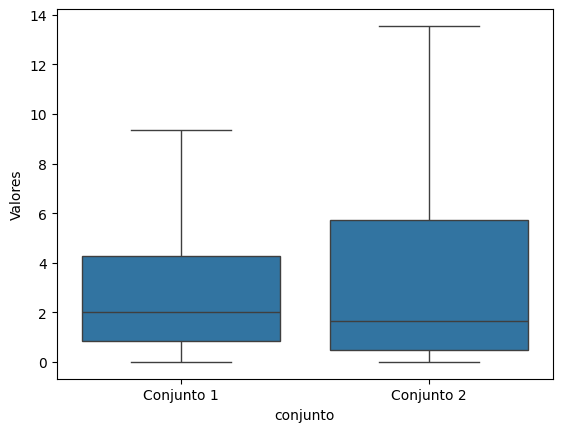

In [150]:
sns.boxplot(x='conjunto', y='valores', data=pd.DataFrame({'conjunto': ['Conjunto 1'] * len(coords_error_c1) + ['Conjunto 2'] * len(coords_error_c2), 'valores': np.concatenate([coords_error_c1, coords_error_c2])}), showfliers=False)

# Adicionar rótulo ao eixo y
plt.ylabel('Valores')


# Exibir o gráfico
plt.show()

## 4. Comparação dos Modelos sobre conjunto de teste

Nessa etapa vamos visualizar o desempenho real do modelo sobre o data set de validação.

Antes, precisamos construir um conjunto reduzido X_teste com os mesmos atributos usados para o conjunto X_treino.

### Alvos Qualitativos

KNN

In [185]:
## KNN
knn_clf = KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='kd_tree', leaf_size=50, p=2)
knn_regr = KNeighborsRegressor(n_neighbors=5, weights='distance', algorithm='kd_tree', leaf_size=50, p=2)

cols = selector.get_support(indices=True)
selected_columns = X.iloc[:,cols].columns.tolist()

Y_new['FLOOR'] = pd.to_numeric(Y['FLOOR'], errors='coerce')
Y_new['BUILDINGID'] = pd.to_numeric(Y['BUILDINGID'], errors='coerce')
X_red = X_teste[selected_columns].to_numpy()

#Fit e predict do classificador
fit = knn_clf.fit(X, Y[CATEGORICAL_COLUMNS])
prediction_clf_c1 = fit.predict(X_teste)
fit = knn_clf.fit(X_reduced_clf, Y_new[CATEGORICAL_COLUMNS])
prediction_clf_c2 = fit.predict(X_red)

#Fit e predict do regressor
fit = knn_regr.fit(X, Y[QUANTITATIVE_COLUMNS])
prediction_reg_c1 = fit.predict(X_teste)
regr_prediction_c1 = DataFrame(prediction_reg_c1, columns=QUANTITATIVE_COLUMNS)
fit = knn_regr.fit(X_reduced_clf, Y_new[QUANTITATIVE_COLUMNS])
prediction_reg_c2 = fit.predict(X_red)
regr_prediction_c2 = DataFrame(prediction_reg_c2, columns=QUANTITATIVE_COLUMNS)

#Métricas de avaliação

acc_clf_c2_knn_flr = accuracy_score(y_teste["FLOOR"].values, prediction_clf_c2[:,0])
acc_clf_c2_knn_bld = accuracy_score(y_teste["BUILDINGID"], prediction_clf_c2[:,1])
acc_clf_c1_knn_flr = accuracy_score(y_teste["FLOOR"].values, prediction_clf_c1[:,0])
acc_clf_c1_knn_bld = accuracy_score(y_teste["BUILDINGID"], prediction_clf_c1[:,1])

mse_reg_c2_knn_log = mean_squared_error(y_teste["LONGITUDE"].values, prediction_reg_c2[:,0])
mse_reg_c2_knn_lat = mean_squared_error(y_teste["LATITUDE"].values, prediction_reg_c2[:,1])
mse_reg_c1_knn_log = mean_squared_error(y_teste["LONGITUDE"].values, prediction_reg_c1[:,0])
mse_reg_c1_knn_lat = mean_squared_error(y_teste["LATITUDE"].values, prediction_reg_c1[:,1])

regr_prediction_c2['LONGITUDE'] = pd.to_numeric(regr_prediction_c2['LONGITUDE'], errors='coerce')
regr_prediction_c2['LATITUDE'] = pd.to_numeric(regr_prediction_c2['LATITUDE'], errors='coerce')

# Calcula o erro
coords_error_c1_knn = localizaion_error(regr_prediction_c1, y_teste)
coords_error_c2_knn = localizaion_error(regr_prediction_c2, y_teste)


SVM

In [189]:
## SVM
svm_clf = SVC(C=150, kernel='rbf', max_iter=3000)
svm_clf = MultiOutputClassifier(svm_clf)
svm_regr = SVR(C=150, kernel="rbf", max_iter=3000)
svm_regr = MultiOutputRegressor(svm_regr)

cols = selector.get_support(indices=True)
selected_columns = X.iloc[:,cols].columns.tolist()

Y_new['FLOOR'] = pd.to_numeric(Y['FLOOR'], errors='coerce')
Y_new['BUILDINGID'] = pd.to_numeric(Y['BUILDINGID'], errors='coerce')
X_red = X_teste[selected_columns].to_numpy()

#Fit e predict do classificador
fit = svm_clf.fit(X, Y[CATEGORICAL_COLUMNS])
prediction_clf_c1 = fit.predict(X_teste)
fit = svm_clf.fit(X_reduced_clf, Y_new[CATEGORICAL_COLUMNS])
prediction_clf_c2 = fit.predict(X_red)

#Fit e predict do regressor
fit = svm_regr.fit(X, Y[QUANTITATIVE_COLUMNS])
prediction_reg_c1 = fit.predict(X_teste)
regr_prediction_c1 = DataFrame(prediction_reg_c1, columns=QUANTITATIVE_COLUMNS)
fit = svm_regr.fit(X_reduced_clf, Y_new[QUANTITATIVE_COLUMNS])
prediction_reg_c2 = fit.predict(X_red)
regr_prediction_c2 = DataFrame(prediction_reg_c2, columns=QUANTITATIVE_COLUMNS)

#Métricas de avaliação

acc_clf_c2_svm_flr = accuracy_score(y_teste["FLOOR"].values, prediction_clf_c2[:,0])
acc_clf_c2_svm_bld = accuracy_score(y_teste["BUILDINGID"], prediction_clf_c2[:,1])
acc_clf_c1_svm_flr = accuracy_score(y_teste["FLOOR"].values, prediction_clf_c1[:,0])
acc_clf_c1_svm_bld = accuracy_score(y_teste["BUILDINGID"], prediction_clf_c1[:,1])

mse_reg_c2_svm_log = mean_squared_error(y_teste["LONGITUDE"].values, prediction_reg_c2[:,0])
mse_reg_c2_svm_lat = mean_squared_error(y_teste["LATITUDE"].values, prediction_reg_c2[:,1])
mse_reg_c1_svm_log = mean_squared_error(y_teste["LONGITUDE"].values, prediction_reg_c1[:,0])
mse_reg_c1_svm_lat = mean_squared_error(y_teste["LATITUDE"].values, prediction_reg_c1[:,1])

regr_prediction_c2['LONGITUDE'] = pd.to_numeric(regr_prediction_c2['LONGITUDE'], errors='coerce')
regr_prediction_c2['LATITUDE'] = pd.to_numeric(regr_prediction_c2['LATITUDE'], errors='coerce')

# Calcula o erro
coords_error_c1_svm = localizaion_error(regr_prediction_c1, y_teste)
coords_error_c2_svm = localizaion_error(regr_prediction_c2, y_teste)


C:\Users\yannm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\yannm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\yannm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=3000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\yannm\AppData\Local\Packages\PythonSoftwareFou

RF

In [190]:
## SVM
rf_clf = RandomForestClassifier(n_estimators=350,max_depth=100)
rf_clf = MultiOutputClassifier(rf_clf)
rf_regr = RandomForestRegressor(n_estimators=350,max_depth=100)
rf_regr = MultiOutputRegressor(rf_regr)

cols = selector.get_support(indices=True)
selected_columns = X.iloc[:,cols].columns.tolist()

Y_new['FLOOR'] = pd.to_numeric(Y['FLOOR'], errors='coerce')
Y_new['BUILDINGID'] = pd.to_numeric(Y['BUILDINGID'], errors='coerce')
X_red = X_teste[selected_columns].to_numpy()

#Fit e predict do classificador
fit = rf_clf.fit(X, Y[CATEGORICAL_COLUMNS])
prediction_clf_c1 = fit.predict(X_teste)
fit = rf_clf.fit(X_reduced_clf, Y_new[CATEGORICAL_COLUMNS])
prediction_clf_c2 = fit.predict(X_red)

#Fit e predict do regressor
fit = rf_regr.fit(X, Y[QUANTITATIVE_COLUMNS])
prediction_reg_c1 = fit.predict(X_teste)
regr_prediction_c1 = DataFrame(prediction_reg_c1, columns=QUANTITATIVE_COLUMNS)
fit = rf_regr.fit(X_reduced_clf, Y_new[QUANTITATIVE_COLUMNS])
prediction_reg_c2 = fit.predict(X_red)
regr_prediction_c2 = DataFrame(prediction_reg_c2, columns=QUANTITATIVE_COLUMNS)

#Métricas de avaliação

acc_clf_c2_rf_flr = accuracy_score(y_teste["FLOOR"].values, prediction_clf_c2[:,0])
acc_clf_c2_rf_bld = accuracy_score(y_teste["BUILDINGID"], prediction_clf_c2[:,1])
acc_clf_c1_rf_flr = accuracy_score(y_teste["FLOOR"].values, prediction_clf_c1[:,0])
acc_clf_c1_rf_bld = accuracy_score(y_teste["BUILDINGID"], prediction_clf_c1[:,1])

mse_reg_c2_rf_log = mean_squared_error(y_teste["LONGITUDE"].values, prediction_reg_c2[:,0])
mse_reg_c2_rf_lat = mean_squared_error(y_teste["LATITUDE"].values, prediction_reg_c2[:,1])
mse_reg_c1_rf_log = mean_squared_error(y_teste["LONGITUDE"].values, prediction_reg_c1[:,0])
mse_reg_c1_rf_lat = mean_squared_error(y_teste["LATITUDE"].values, prediction_reg_c1[:,1])

regr_prediction_c2['LONGITUDE'] = pd.to_numeric(regr_prediction_c2['LONGITUDE'], errors='coerce')
regr_prediction_c2['LATITUDE'] = pd.to_numeric(regr_prediction_c2['LATITUDE'], errors='coerce')

# Calcula o erro
coords_error_c1_rf = localizaion_error(regr_prediction_c1, y_teste)
coords_error_c2_rf = localizaion_error(regr_prediction_c2, y_teste)


Estatísticas

In [191]:
estatistica_clf = {
    'Estatística': ['KNN','SVM','RF'],
    'Conjunto 1 Floor': [acc_clf_c1_knn_flr,acc_clf_c1_svm_flr,acc_clf_c1_rf_flr],
    'Conjunto 2 Floor': [acc_clf_c2_knn_flr,acc_clf_c2_svm_flr,acc_clf_c2_rf_flr],
    'Conjunto 1 Building': [acc_clf_c1_knn_bld,acc_clf_c1_svm_bld,acc_clf_c1_rf_bld],
    'Conjunto 2 Building': [acc_clf_c2_knn_bld,acc_clf_c2_svm_bld,acc_clf_c2_rf_bld]
}

df_stat_clf = pd.DataFrame(estatistica_clf)
display(df_stat_clf)

,Estatística,Conjunto 1 Floor,Conjunto 2 Floor,Conjunto 1 Building,Conjunto 2 Building
0,KNN,0.911791,0.247525,0.994599,0.482448
1,SVM,0.908191,0.298830,0.997300,0.657066
2,RF,0.910891,0.217822,0.999100,0.667867


In [192]:
estatistica_reg = {
    'Estatística': ['KNN','SVM','RF'],
    'Conjunto 1 Latitude (m)': [mse_reg_c1_knn_lat,mse_reg_c1_svm_lat,mse_reg_c1_rf_lat],
    'Conjunto 2 Latitude (m)': [mse_reg_c2_knn_lat,mse_reg_c2_svm_lat,mse_reg_c2_rf_lat],
    'Conjunto 1 Longitude (m)': [mse_reg_c1_knn_log,mse_reg_c1_svm_log,mse_reg_c1_rf_log],
    'Conjunto 2 Longitude (m)': [mse_reg_c2_knn_log,mse_reg_c2_svm_log,mse_reg_c2_rf_log]
}

df_stat_reg = pd.DataFrame(estatistica_reg)
display(df_stat_reg)

,Estatística,Conjunto 1 Latitude (m),Conjunto 2 Latitude (m),Conjunto 1 Longitude (m),Conjunto 2 Longitude (m)
0,KNN,112.055097,5984.373910,209.465523,15222.444183
1,SVM,207.265485,3663.388822,767.681779,9409.456374
2,RF,213.863123,8930.451217,210.841429,14689.280246


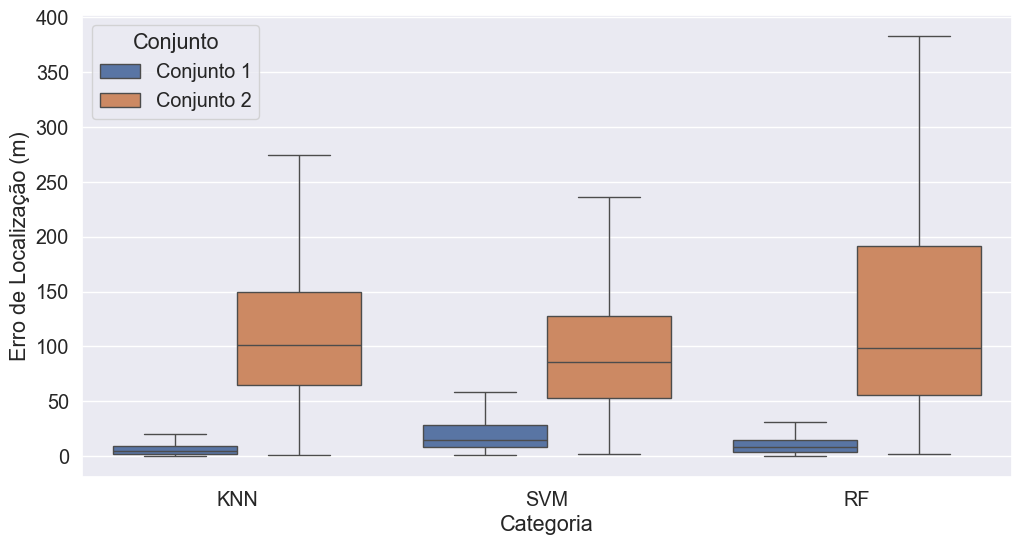

In [207]:
# Criar rótulos de categoria para cada conjunto de dados
categorias = ['KNN'] * len(coords_error_c1_knn) + ['SVM'] * len(coords_error_c1_svm) + ['Categoria3'] * len(coords_error_c1_rf)

# Criar um DataFrame para cada conjunto de dados
df1 = pd.DataFrame({'Categoria': ['KNN'] * len(coords_error_c1_knn),'Conjunto': ['Conjunto 1'] * len(coords_error_c1_knn), 'Erro de Localização (m)': coords_error_c1_knn})
df2 = pd.DataFrame({'Categoria': ['KNN'] * len(coords_error_c2_knn),'Conjunto': ['Conjunto 2'] * len(coords_error_c2_knn), 'Erro de Localização (m)': coords_error_c2_knn})
df3 = pd.DataFrame({'Categoria': ['SVM'] * len(coords_error_c1_svm),'Conjunto': ['Conjunto 1'] * len(coords_error_c1_knn), 'Erro de Localização (m)': coords_error_c1_svm})
df4 = pd.DataFrame({'Categoria': ['SVM'] * len(coords_error_c2_svm),'Conjunto': ['Conjunto 2'] * len(coords_error_c2_knn), 'Erro de Localização (m)': coords_error_c2_svm})
df5 = pd.DataFrame({'Categoria': ['RF'] * len(coords_error_c1_rf),'Conjunto': ['Conjunto 1'] * len(coords_error_c1_knn), 'Erro de Localização (m)': coords_error_c1_rf})
df6 = pd.DataFrame({'Categoria': ['RF'] * len(coords_error_c2_rf),'Conjunto': ['Conjunto 2'] * len(coords_error_c2_knn), 'Erro de Localização (m)': coords_error_c2_rf})

# Juntar todos os DataFrames em um único DataFrame
df = pd.concat([df1, df2, df3, df4, df5, df6])
sns.set(font_scale=1.3)
# Plotar os boxplots agrupados 2 a 2
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['Categoria'], y=df['Erro de Localização (m)'], hue=df['Conjunto'], dodge=True, showfliers=False)
#plt.title('Boxplots Agrupados 2 a 2')
plt.show()

In [209]:
sem_outliers_c2_knn = coords_error_c2_knn[~((coords_error_c2_knn - np.mean(coords_error_c2_knn)) > 3 * np.std(coords_error_c2_knn))]
sem_outliers_c2_svm = coords_error_c2_svm[~((coords_error_c2_svm - np.mean(coords_error_c2_svm)) > 3 * np.std(coords_error_c2_svm))]
sem_outliers_c2_rf = coords_error_c2_rf[~((coords_error_c2_rf - np.mean(coords_error_c2_rf)) > 3 * np.std(coords_error_c2_rf))]
sem_outliers_c1_knn = coords_error_c1_knn[~((coords_error_c1_knn - np.mean(coords_error_c1_knn)) > 3 * np.std(coords_error_c1_knn))]
sem_outliers_c1_svm = coords_error_c1_svm[~((coords_error_c1_svm - np.mean(coords_error_c1_svm)) > 3 * np.std(coords_error_c1_svm))]
sem_outliers_c1_rf = coords_error_c1_rf[~((coords_error_c1_rf - np.mean(coords_error_c1_rf)) > 3 * np.std(coords_error_c1_rf))]

estatistica_bxp = {
    'Estatística': ['KNN','SVM','RF','KNN','SVM','RF'],
    'Conjunto 1 (Com Outliers)': [np.mean(coords_error_c1_knn),np.std(coords_error_c1_knn), np.mean(coords_error_c1_svm),np.std(coords_error_c1_svm), np.mean(coords_error_c1_rf), np.std(coords_error_c1_rf)],
    'Conjunto 2 (Com Outliers)': [np.mean(coords_error_c2_knn),np.std(coords_error_c2_knn), np.mean(coords_error_c2_svm),np.std(coords_error_c2_svm), np.mean(coords_error_c2_rf), np.std(coords_error_c2_rf)],
    'Conjunto 1 (Sem Outliers)': [np.mean(sem_outliers_c1_knn),np.std(sem_outliers_c1_knn), np.mean(sem_outliers_c1_svm),np.std(sem_outliers_c1_svm), np.mean(sem_outliers_c1_rf), np.std(sem_outliers_c1_rf)],
    'Conjunto 2 (Sem Outliers)': [np.mean(sem_outliers_c2_knn),np.std(sem_outliers_c2_knn), np.mean(sem_outliers_c2_svm),np.std(sem_outliers_c2_svm), np.mean(sem_outliers_c2_rf), np.std(sem_outliers_c2_rf)]
}

df_stat_bxp = pd.DataFrame(estatistica_bxp)
display(df_stat_bxp)

,Estatística,Conjunto 1 (Com Outliers),Conjunto 2 (Com Outliers),Conjunto 1 (Sem Outliers),Conjunto 2 (Sem Outliers)
0,KNN,8.418421,120.207219,7.391126,118.828861
1,SVM,15.831955,82.201232,8.010640,80.261426
2,RF,22.241959,97.257612,20.292804,94.349488
3,KNN,21.914436,60.114907,17.506774,55.473859
4,SVM,13.207153,126.030402,11.369261,125.785341
5,RF,15.820103,87.954927,11.118038,87.614597
